## Setup packages

In [355]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from keras import metrics
from matplotlib import rcParams

In [508]:
# load data
pickle_name = str('_data_manuscript')

combo_df_norm = pd.read_pickle(f'combo_df_norm{pickle_name}.pkl')

with open(f'means_train_dict{pickle_name}.pkl', 'rb') as handle:
    means_train_dict = pickle.load(handle)

with open(f'stds_train_dict{pickle_name}.pkl', 'rb') as handle:
    stds_train_dict = pickle.load(handle)

with open(f'features_considered{pickle_name}.pkl', 'rb') as handle:
    features_considered = pickle.load(handle)

In [507]:
pre_seasoned = combo_df_norm

seasoned_spring = pre_seasoned[pre_seasoned.index.month > 3]
seasoned_spring = seasoned_spring[seasoned_spring.index.month < 7]
seasoned_summer = pre_seasoned[pre_seasoned.index.month > 6]
seasoned_summer = seasoned_summer[seasoned_summer.index.month < 9]
seasoned_fall = pre_seasoned[pre_seasoned.index.month >8]
seasoned_fall = seasoned_fall[seasoned_fall.index.month < 11]

seasoned_all = pre_seasoned[pre_seasoned.index.month >3]
seasoned_all = seasoned_all[seasoned_all.index.month < 11]

season_selected = seasoned_all

if season_selected.equals(pre_seasoned): 
    season_name = ('pre_seasoned')

if season_selected.equals(seasoned_all): 
    season_name = ('seasoned_all')

if season_selected.equals(seasoned_fall): 
    season_name = ('seasoned_fall')

if season_selected.equals(seasoned_summer): 
    season_name = ('seasoned_summer')
    
if season_selected.equals(seasoned_spring): 
    season_name = ('seasoned_spring')

for count, col in enumerate(season_selected.columns):
    if season_selected[col].isna().any():
        print(col, 'now has', season_selected[col].isna().sum(), 'empty values')

In [358]:
# multi-step CNN-LSTM Encoder-Decoder Model using convlstm 
# modified from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

def split_dataset(train_in, test_in, future=1): 
    
    train = train_in
    test = test_in[1:-future]
    
    print(len(test), 'len test')
    print(len(train), 'len train')
    remainder = len(train)%future
    end_point = len(train) - remainder
    
    if remainder:
        print('remainder trimmed from train is:', remainder)
        train = train[:end_point]
    
    remainder = len(test)%future
    end_point = len(test) - remainder
    
    if remainder:
        print('remainder trimmed from test is:', remainder)
        test = test[:end_point] 
        
    train_size = len(train)
    train_length = len(train)
    test_length = len(test)
    print('train_size is:', train_size, 'future is:', future)
    print('len test is:', test_length)
    
    array_splits = int(int(train_length)/future)
    print('array_splits train', array_splits)
    train = np.array(np.split(train, array_splits)) 
    
    array_splits = int(int(test_length)/future)
    print('array_splits test', array_splits)
    test = np.array(np.split(test, array_splits))

    return train.squeeze(), test.squeeze(), train_size

def multivariate_past(data, past, future, size_data):

    past_data, future_data = list(), list()
    mid_point = past + 1

    for x in range(len(data)):

        past_start = mid_point - past
        future_end = mid_point + future 
        
        if future_end <= size_data: 

            past_data.append(data[past_start:mid_point, :,:]) 

        mid_point += 1
        
    return np.array(past_data)

def multivariate_pastfuture(data, past, future, size_data):

    past_future_data, future_data = list(), list()
    mid_point = past+1

    for x in range(size_data):

        past_start = mid_point - past
        future_end = mid_point + future  
                
        if future_end <= size_data: 

            past_future_data.append(data[:,:,past_start:future_end])

        mid_point += 1
        
    return np.array(past_future_data)

In [ ]:
future = 7 
past = 21
pseudo_row = 5 
pseudo_col = 6
new_start = 1996 
this_year = 2021
this_month = 7

def find_double_years(data):
    season_selected_dated = data[:]
    season_selected_dated['date_index'] = season_selected_dated.index
    drop_keys = []
    for x,num in enumerate(season_selected_dated.iterrows()):

        if x > past and x + future < len(season_selected_dated):
            if (str(season_selected_dated['date_index'][x-past])[0:4])==(str(season_selected_dated['date_index'][x+future])[0:4]):
                continue
            else:
                drop_keys.append(np.round(np.round(season_selected_dated['cfs_waterton'][x],8)+
                                          (np.round(season_selected_dated['days_past'][x],8)),8))
    return drop_keys

drop_keys = find_double_years(season_selected)

train_in = season_selected.loc[f'{new_start}-01-01':f'{2012}-12-31']
train_in_late = season_selected.loc[f'{2017}-01-01':f'{this_year}-{this_month}-01']
train_in = train_in.merge(train_in_late,how='outer')
val_in = season_selected.loc[f'{2013}-01-01':f'{2014}-12-31']

print(train_in.shape,'train_in')
print(val_in.shape,'val_in')

print('drop_keys len', len(drop_keys))
print(season_selected.shape)

testing_data = season_selected.loc[f'{2015}-01-01':f'{2016}-12-31'] 

In [ ]:
train_square, val_square, train_size = split_dataset(train_in, val_in, 1) 
train_square = train_square.reshape(train_square.shape[0], pseudo_row, pseudo_col, order='F')
val_square = val_square.reshape(val_square.shape[0], pseudo_row, pseudo_col, order='F')

In [ ]:
train_past_data = multivariate_past(train_square, past, future, train_square.shape[0]) 
val_past_data = multivariate_past(val_square, past, future, val_square.shape[0]) 

def pad_data(data):
    padded_data = data[:]
    padded_data = np.expand_dims(train_past_data, axis=4)
    padded_data = np.pad(data,((0,0),(0,future),(0,0),(0,0)),'edge')
    return padded_data

train_padded = pad_data(train_past_data)
val_padded = pad_data(val_past_data)

In [ ]:
train_square2 = train_square.ravel(order='F')
val_square2 = val_square.ravel(order='F')

train_square2 = train_square2.reshape(pseudo_col,pseudo_row,train_square.shape[0],order='C')
val_square2 = val_square2.reshape(pseudo_col,pseudo_row,val_square.shape[0],order='C')

train_square2 = train_square2.swapaxes(0,1)
val_square2 = val_square2.swapaxes(0,1)

train_future_data = multivariate_pastfuture(train_square2, past, future, train_square.shape[0]) 
val_future_data = multivariate_pastfuture(val_square2, past, future, val_square.shape[0]) 

train_y = np.expand_dims(train_future_data,axis=1)
val_y = np.expand_dims(val_future_data,axis=1)

train_y = train_y.transpose([0,4,2,3,1])
val_y = val_y.transpose([0,4,2,3,1])

train_y2 = train_y [:, past:past+future, :, :, :]
val_y2 = val_y [:, past:past+future, :, :, :]
train_x2 = np.expand_dims(train_padded,axis=4)
val_x2 = np.expand_dims(val_padded,axis=4)
train_x2 = np.expand_dims(train_x2,axis=4)
val_x2 = np.expand_dims(val_x2,axis=4)
train_y2 = np.expand_dims(train_y2,axis=4)
val_y2 = np.expand_dims(val_y2,axis=4)

In [363]:
def drop_double_rows(data):
    data2=data[:]
    counter = 0
    drop_row_list = []
    for count,row in enumerate(data2[:,0,0,0,0]):

        key_match = np.round(([np.round(data2[count, 0, 0, 2, 0],8)][0]) + 
            ([np.round(data2[count, 0, 2, 3, 0],8)][0]),8)

        if np.round(key_match, 8) in drop_keys:
            counter += 1
            drop_row_list.append(count)

    print('rows dropped:', counter)
    return drop_row_list

In [ ]:
drop_row_list = drop_double_rows(train_y2)
train_x2 = np.delete(train_x2,[drop_row_list], axis=0)
train_y2 = np.delete(train_y2,[drop_row_list], axis=0)

In [ ]:
drop_row_list = drop_double_rows(val_y2)
val_x2 = np.delete(val_x2,[drop_row_list], axis=0)
val_y2 = np.delete(val_y2,[drop_row_list], axis=0)

In [366]:
def custom_loss_MAE(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    full_future_error=(tf.abs(tf.math.subtract(y_pred, y_true)))
    return full_future_error

In [367]:
future = 7
past = 21
col = 5
row = 6
input_shape = (future+past, 5, 6, 1, 1)
reg_value = 1e-6
filter_size = 8

In [368]:
def LSTM2D_Model(input_shape, reg_value):
    encoder_input_one = keras.Input(shape = input_shape, 
                                    name = 'input_layer')
    reshape_layer = keras.layers.Reshape([28, 5, 6, 1, ])(encoder_input_one)
    conv_layer = keras.layers.ConvLSTM2D(1, 3, padding = 'same', name = 'conv2dlayer',
                                        return_sequences = True, 
                                           
                                        kernel_initializer="glorot_uniform",
                                        recurrent_initializer="orthogonal",
                                        bias_initializer="glorot_uniform",
                                        recurrent_activation="hard_sigmoid",
                                                                    
                                        kernel_regularizer=regularizers.l2(reg_value), 
                                        recurrent_regularizer= regularizers.l2(reg_value), 
                                        bias_regularizer= regularizers.l2(reg_value),
                                        activity_regularizer= regularizers.l2(reg_value),
                                        dropout = 0.3,
                                        recurrent_dropout = 0.3,
                                        data_format = 'channels_last')(reshape_layer)

    future_only = tf.slice(conv_layer,begin=[0,20,0,0,0],size=[-1,7,5,6,1])
    conv_layer2  =  keras.layers.ConvLSTM2D(1, 3, padding='same', name = 'conv2dlayer2',
                                            return_sequences = True, 

                                            kernel_initializer="glorot_uniform",
                                            recurrent_initializer="orthogonal",
                                            bias_initializer="glorot_uniform",                             
                                            recurrent_activation="hard_sigmoid",
                                                                            
                                            kernel_regularizer=regularizers.l2(reg_value), 
                                            recurrent_regularizer= regularizers.l2(reg_value), 
                                            bias_regularizer= regularizers.l2(reg_value),
                                            activity_regularizer= regularizers.l2(reg_value),
                                            dropout = 0.3,
                                            recurrent_dropout = 0.3,
                                            data_format = 'channels_last')(future_only)

    time_dist2 = keras.layers.TimeDistributed(keras.layers.Dense(1), name='TD2')(conv_layer2)

    out_shape = tf.expand_dims(time_dist2, axis=-1)

    model_out = keras.Model(encoder_input_one, out_shape, name = 'conv2d')
    
    return model_out

model_additive = LSTM2D_Model(input_shape,reg_value)
print(model_additive.summary())

Model: "conv2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 5, 6, 1, 1)]  0         
                                                                 
 reshape_73 (Reshape)        (None, 28, 5, 6, 1)       0         
                                                                 
 conv2dlayer (ConvLSTM2D)    (None, 28, 5, 6, 1)       76        
                                                                 
 tf.slice_219 (TFOpLambda)   (None, 7, 5, 6, 1)        0         
                                                                 
 conv2dlayer2 (ConvLSTM2D)   (None, 7, 5, 6, 1)        76        
                                                                 
 TD2 (TimeDistributed)       (None, 7, 5, 6, 1)        2         
                                                                 
 tf.expand_dims_73 (TFOpLamb  (None, 7, 5, 6, 1, 1)    0    

train_x2 (4530, 28, 5, 6, 1, 1)
epoch_steps 90
Epoch 1/100
90/90 [==============================] - 15s 95ms/step - loss: 0.6646 - mean_absolute_error: 0.6645 - val_loss: 0.6254 - val_mean_absolute_error: 0.6251
Epoch 2/100
90/90 [==============================] - 7s 81ms/step - loss: 0.5834 - mean_absolute_error: 0.5832 - val_loss: 0.5231 - val_mean_absolute_error: 0.5228
Epoch 3/100
90/90 [==============================] - 7s 81ms/step - loss: 0.5279 - mean_absolute_error: 0.5277 - val_loss: 0.4463 - val_mean_absolute_error: 0.4460
Epoch 4/100
90/90 [==============================] - 7s 83ms/step - loss: 0.4931 - mean_absolute_error: 0.4930 - val_loss: 0.4106 - val_mean_absolute_error: 0.4105
Epoch 5/100
90/90 [==============================] - 7s 82ms/step - loss: 0.4785 - mean_absolute_error: 0.4784 - val_loss: 0.3986 - val_mean_absolute_error: 0.3985
Epoch 6/100
90/90 [==============================] - 7s 83ms/step - loss: 0.4686 - mean_absolute_error: 0.4685 - val_loss: 0.3929 - 

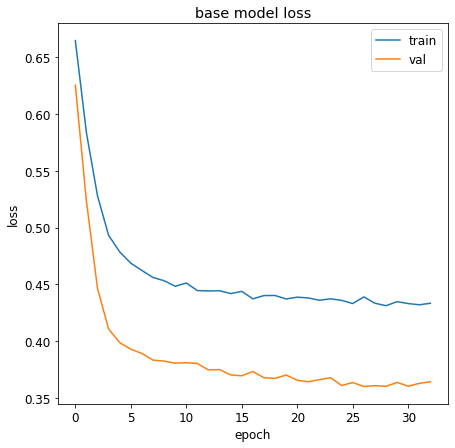

In [369]:
# Base model 
rcParams['figure.figsize'] = (7,7)
batch_size = 50
PATIENCE = 6
reg_value = 1e-6

verbose, epochs = 1, 100 

arr_weight_train = np.ones(shape=(train_x2.shape[0],7,5,6,1,1))
arr_weight_test = np.ones(shape=(val_x2.shape[0],7,5,6,1,1)) 

model_base = LSTM2D_Model(input_shape,reg_value)

optimizer = keras.optimizers.RMSprop(learning_rate = 0.003, clipvalue=1.0)
model_base.compile(optimizer, 
                   metrics=[metrics.mae],
                   loss=custom_loss_MAE)

epoch_steps = len(train_x2)//batch_size
print('epoch_steps', epoch_steps)
early_stopping = EarlyStopping(monitor=('loss'), patience = PATIENCE, 
                           mode='min', verbose=1, restore_best_weights=True)
early_stopping_val = EarlyStopping(monitor=('val_loss'), patience=PATIENCE, 
                           mode='min', verbose=1, restore_best_weights=True)

history = model_base.fit(train_x2, train_y2, epochs=epochs, batch_size=batch_size, 
                            verbose = verbose, steps_per_epoch=epoch_steps, 
                            sample_weight = arr_weight_train,
                            validation_data=(val_x2, val_y2, arr_weight_test),
                            shuffle=True,
                            callbacks=[early_stopping,early_stopping_val]) 

model_base_2DLSTM = model_base 
base_weights_2DLSTM = model_base.get_weights()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'],label='val')
plt.title('base model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [370]:
features_modeled = ['cfs_TARRYALL_BORDEN','cfs_roberts', 'cfs_deckers', 'cfs_grant', 'cfs_below_brush', 'cfs_below_dillon', 
                    'cfs_waterton', 'cfs_bailey', 'cfs_cheesman_inflow', 'cfs_above_chatfield', 
                    'cfs_below_strontia',  'cfs_cheesman_res', 'cfs_homestake_pipeline', 'cfs_above_spinney',
                    'cfs_11mile_outflow', 'cfs_11mileinflow',  
                    ]

In [371]:
def create_daily_forecast(dataset, future_dataset, day_number, future, features_considered, past, model):
  
    future_days = future_dataset[day_number:day_number+1,:,:,:,:]
    future_data2 = np.squeeze(np.array(future_days)) 
    future_data2 = future_data2.transpose([1,2,0])
    future_day = future_data2.reshape((5 * 6), future, order='F')
    future_days = future_day.transpose([1,0])
    future_days = pd.DataFrame(future_days)
    future_days.columns = features_considered 

    prior_time = dataset[day_number,0:past,:,:,:]
    prior_days = np.squeeze(np.array(prior_time)) 
    prior_days = prior_days.transpose([1,2,0])
    prior_days = prior_days.reshape((5 * 6), past, order='F')
    prior_days = prior_days.transpose([1,0])
    prior_days = pd.DataFrame(prior_days)
    prior_days.columns = features_considered 
    
    test_data = dataset[day_number:day_number+1,:,:,:,:,:]
    forecast_weekly = model(test_data, training=False)
    forecast_weekly = forecast_weekly[0,0:future,:,:,0]
    forecast_weekly = np.squeeze(np.array(forecast_weekly))
    forecast_weekly = forecast_weekly.transpose([1,2,0])
    forecast_week = forecast_weekly.reshape((5 * 6), future, order='F')
    forecast_week = forecast_week.transpose([1,0])
    forecast_week = pd.DataFrame(forecast_week)
    forecast_week.columns = features_considered 
    return prior_days, future_days, forecast_week

In [441]:
def create_persistence_list_from_base(model_set, dataset, future_dataset, features_modeled):

    persistence_list = {}

    for gauge_num, gauge in enumerate(features_modeled):

        name_model = gauge
        persistence_list[f'{name_model}'] = []

        for day_number in range(len(dataset)):

            prior_days, future_days, forecast_week = create_daily_forecast(dataset,
                       future_dataset, day_number,future,features_considered,
                       past, model_set)

            future_points, predicted_points, history_points = [], [], []

            future_points.append((future_days[name_model] * stds_train_dict[name_model]) + 
                         means_train_dict[name_model])
            history_points.append((prior_days[name_model] * stds_train_dict[name_model]) + 
                      means_train_dict[name_model])
            predicted_points.append((forecast_week[name_model] * stds_train_dict[name_model]) + 
                            means_train_dict[name_model])
        
            tot_days1,tot_days2,tot_days3,tot_days4,tot_days5,tot_days6,tot_days7 = (0,0,0,0,0,0,0)
            tot_error = 0

            gauge_error = abs(np.array(future_points) - np.array(predicted_points))   

            tot_days1 = tot_days1 + gauge_error[0,0] 
            tot_days2 = tot_days2 + gauge_error[0,1]
            tot_days3 = tot_days3 + gauge_error[0,2]
            tot_days4 = tot_days4 + gauge_error[0,3]
            tot_days5 = tot_days5 + gauge_error[0,4]
            tot_days6 = tot_days6 + gauge_error[0,5]
            tot_days7 = tot_days7 + gauge_error[0,6]

            tot_error = tot_error + tot_days1 + tot_days2 + tot_days3 + tot_days4 + tot_days5 + tot_days6 + tot_days7
            persistence = np.array(history_points[0].iloc[-1])

            persistence = persistence.repeat(future)
            persistence_tot_error = np.sum(abs(np.subtract(np.array(future_points), persistence)))
            
            if persistence_tot_error < 0.00001:
                persistence_tot_error = 0.00001

            else:
                persistence_tot_error = np.round(persistence_tot_error,2)
            
            persistence_benefit = np.round(np.round(tot_error,2) / persistence_tot_error,2)

            persistence_list[f'{name_model}'].append(persistence_benefit)
            
    return persistence_list

In [ ]:
# creating dataset for classification

persistence_benefit_val_list2 = create_persistence_list_from_base(model_base_2DLSTM, 
                                                                    val_x2, val_y2, features_modeled)
persistence_benefit_train_list2 = create_persistence_list_from_base(model_base_2DLSTM, 
                                                                    train_x2, train_y2, features_modeled)

pickle_name = str('Persist_Benefit_List_manuscript')

# with open(f'{pickle_name}_train_list.pkl', 'rb') as handle:
#     persistence_benefit_train_list2 = pickle.load(handle)

# with open(f'{pickle_name}_val_list.pkl', 'rb') as handle:
#     persistence_benefit_val_list2 = pickle.load(handle)

train_list = (list(persistence_benefit_train_list2))
train_list = (list(persistence_benefit_val_list2))

In [376]:
pickle_name = str('Persist_Benefit_List_manuscript')

file_to_write = open(f'{pickle_name}_train_list.pkl', 'wb')
pickle.dump(persistence_benefit_train_list2, file_to_write)
file_to_write.close()

file_to_write = open(f'{pickle_name}_val_list.pkl', 'wb')
pickle.dump(persistence_benefit_val_list2, file_to_write)
file_to_write.close()

In [377]:
# Classifier
def Conv_Classification(input_shape, future, past, filter_size, col, row):
    classify_input_one = keras.Input(shape = input_shape, name = 'input_layer')
    squeeze_in = tf.squeeze(classify_input_one, axis = -1)
    past_only = tf.slice(squeeze_in, begin=[0,0,0,0,0],size=[-1,21,5,6,1])

    reshape = tf.transpose(past_only,[0,4,2,3,1])
    
    conv_layer = keras.layers.Conv3D(1,3,padding='same',
                                    kernel_initializer="glorot_uniform",
                                    bias_initializer="zeros",
                                    kernel_regularizer=regularizers.l2(reg_value), 
                                    bias_regularizer= regularizers.l2(reg_value),
                                    activity_regularizer= regularizers.l2(reg_value),
                                      )(reshape)

    squeeze_two = tf.squeeze(conv_layer, axis = -1)
    squeeze_three = tf.squeeze(squeeze_two, axis =  1)
    future_one = tf.slice(squeeze_three, begin=[0,col,row,], size=[-1,1,1])
    squeeze_four = tf.squeeze(future_one, axis =  1)
    activation_layer = tf.keras.activations.sigmoid(squeeze_four)
    model_out = keras.Model(classify_input_one, activation_layer, name='classify_Simple3D')

    return model_out

model_additive = Conv_Classification((28, 5, 6, 1, 1), future, past, filter_size, 1,2)

print(model_additive.summary())

Model: "classify_Simple3D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 28, 5, 6, 1, 1)]  0         
                                                                 
 tf.compat.v1.squeeze_292 (T  (None, 28, 5, 6, 1)      0         
 FOpLambda)                                                      
                                                                 
 tf.slice_221 (TFOpLambda)   (None, 21, 5, 6, 1)       0         
                                                                 
 tf.compat.v1.transpose_73 (  (None, 1, 5, 6, 21)      0         
 TFOpLambda)                                                     
                                                                 
 conv3d_73 (Conv3D)          (None, 1, 5, 6, 1)        568       
                                                                 
 tf.compat.v1.squeeze_293 (T  (None, 1, 5, 6)    

cfs_conduit26
skipping cfs_conduit26
cfs_conduit20
skipping cfs_conduit20
Tmax-1
skipping Tmax-1
Tmax-2
skipping Tmax-2
Tmax-4
skipping Tmax-4
cfs_roberts
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_roberts_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 3s 15ms/step - loss: 4.5509e-06 - val_loss: 1.8547e-06
Epoch 2/15
90/90 [==============================] - 1s 11ms/step - loss: 1.4905e-06 - val_loss: 9.2587e-07
Epoch 3/15
90/90 [==============================] - 1s 10ms/step - loss: 7.5643e-07 - val_loss: 4.8195e-07
Epoch 4/15
90/90 [==============================] - 1s 10ms/step - loss: 4.0633e-07 - val_loss: 2.7051e-07
Epoch 5/15
90/90 [==============================] - 1s 10ms/step - loss: 2.3535e-07 - val_loss: 1.6061e-07


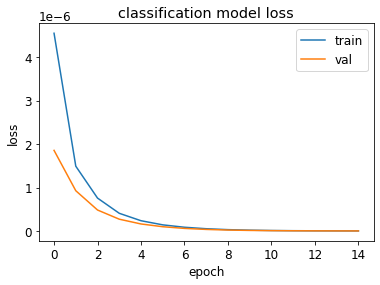

cfs_deckers
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_deckers_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 14ms/step - loss: 3.2308e-06 - val_loss: 1.4536e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.0494e-06 - val_loss: 6.1227e-07
Epoch 3/15
90/90 [==============================] - 1s 10ms/step - loss: 4.3492e-07 - val_loss: 2.5055e-07
Epoch 4/15
90/90 [==============================] - 1s 11ms/step - loss: 1.7682e-07 - val_loss: 1.0347e-07
Epoch 5/15
90/90 [==============================] - 1s 10ms/step - loss: 7.5102e-08 - val_loss: 4.5399e-08
Epoch 6/15
90/90 [==============================] - 1s 10ms/step - loss: 3.3784e-08 - val_loss: 2.1480e-08
Epoch 7/15
90/90 [===================

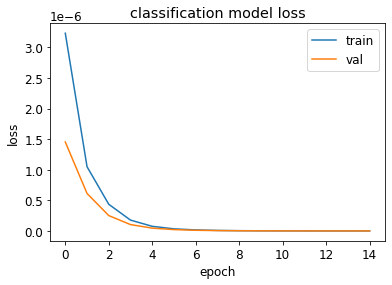

cfs_grant
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_grant_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 12ms/step - loss: 4.5838e-06 - val_loss: 2.0118e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.6311e-06 - val_loss: 9.8655e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 8.1298e-07 - val_loss: 5.0232e-07
Epoch 4/15
90/90 [==============================] - 1s 10ms/step - loss: 4.2446e-07 - val_loss: 2.7160e-07
Epoch 5/15
90/90 [==============================] - 1s 10ms/step - loss: 2.3558e-07 - val_loss: 1.5710e-07
Epoch 6/15
90/90 [==============================] - 1s 9ms/step - loss: 1.3882e-07 - val_loss: 9.4245e-08
Epoch 7/15
90/90 [=========================

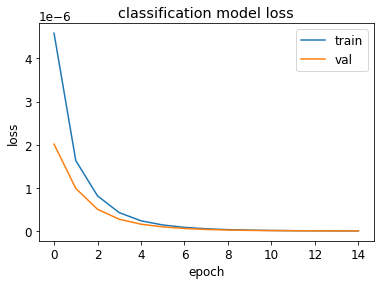

cfs_below_brush
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_below_brush_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 13ms/step - loss: 4.5732e-06 - val_loss: 1.8319e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.5147e-06 - val_loss: 9.6797e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 8.1529e-07 - val_loss: 5.3071e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 4.5843e-07 - val_loss: 3.0901e-07
Epoch 5/15
90/90 [==============================] - 1s 10ms/step - loss: 2.7234e-07 - val_loss: 1.8884e-07
Epoch 6/15
90/90 [==============================] - 1s 11ms/step - loss: 1.6629e-07 - val_loss: 1.1718e-07
Epoch 7/15
90/90 [=============

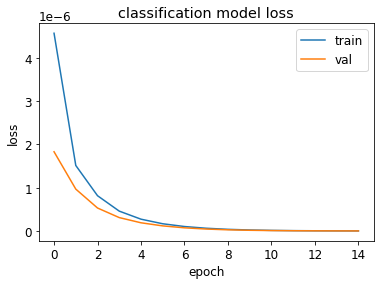

cfs_below_dillon
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_below_dillon_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 12ms/step - loss: 4.1310e-06 - val_loss: 1.7420e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.3276e-06 - val_loss: 7.6480e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 5.9273e-07 - val_loss: 3.4532e-07
Epoch 4/15
90/90 [==============================] - 1s 10ms/step - loss: 2.7188e-07 - val_loss: 1.6302e-07
Epoch 5/15
90/90 [==============================] - 1s 10ms/step - loss: 1.3246e-07 - val_loss: 8.3388e-08
Epoch 6/15
90/90 [==============================] - 1s 11ms/step - loss: 6.9868e-08 - val_loss: 4.6132e-08
Epoch 7/15
90/90 [==========

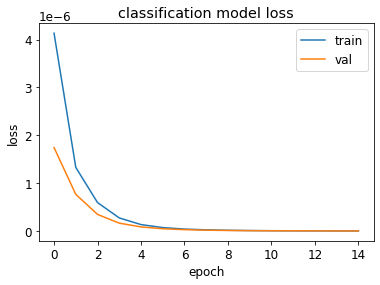

cfs_waterton
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_waterton_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 11ms/step - loss: 4.6436e-06 - val_loss: 1.6507e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.2209e-06 - val_loss: 7.0487e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 5.3871e-07 - val_loss: 3.2164e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 2.5389e-07 - val_loss: 1.5651e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 1.2852e-07 - val_loss: 8.3312e-08
Epoch 6/15
90/90 [==============================] - 1s 11ms/step - loss: 7.0499e-08 - val_loss: 4.7642e-08
Epoch 7/15
90/90 [====================

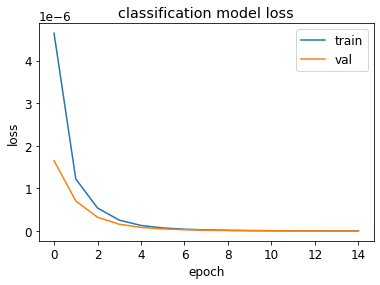

cfs_bailey
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_bailey_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 12ms/step - loss: 4.4052e-06 - val_loss: 1.9086e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.5217e-06 - val_loss: 8.8698e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 7.1698e-07 - val_loss: 4.2314e-07
Epoch 4/15
90/90 [==============================] - 1s 8ms/step - loss: 3.4909e-07 - val_loss: 2.1212e-07
Epoch 5/15
90/90 [==============================] - 1s 8ms/step - loss: 1.8029e-07 - val_loss: 1.1278e-07
Epoch 6/15
90/90 [==============================] - 1s 9ms/step - loss: 9.7541e-08 - val_loss: 6.2746e-08
Epoch 7/15
90/90 [=========================

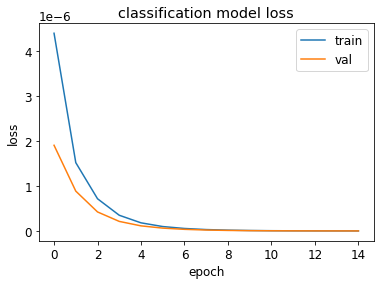

cfs_cheesman_inflow
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_cheesman_inflow_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 12ms/step - loss: 4.1559e-06 - val_loss: 1.7751e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.3779e-06 - val_loss: 7.8287e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 6.1666e-07 - val_loss: 3.6268e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 2.9766e-07 - val_loss: 1.8437e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 1.5834e-07 - val_loss: 1.0186e-07
Epoch 6/15
90/90 [==============================] - 1s 9ms/step - loss: 8.9845e-08 - val_loss: 5.9806e-08
Epoch 7/15
90/90 [=======

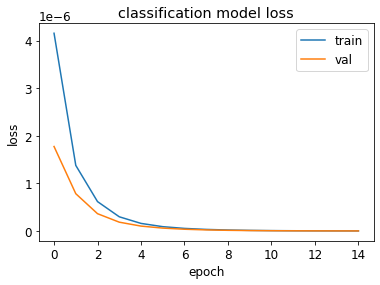

cfs_above_chatfield
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_above_chatfield_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 12ms/step - loss: 7.1876e-06 - val_loss: 2.4133e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.9137e-06 - val_loss: 1.2244e-06
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 1.0807e-06 - val_loss: 7.5163e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 7.0996e-07 - val_loss: 5.2400e-07
Epoch 5/15
90/90 [==============================] - 1s 10ms/step - loss: 5.0861e-07 - val_loss: 3.8469e-07
Epoch 6/15
90/90 [==============================] - 1s 10ms/step - loss: 3.7255e-07 - val_loss: 2.8646e-07
Epoch 7/15
90/90 [=====

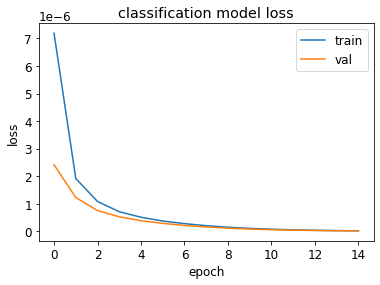

cfs_below_strontia
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_below_strontia_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 1s 10ms/step - loss: 5.0408e-06 - val_loss: 2.2871e-06
Epoch 2/15
90/90 [==============================] - 1s 8ms/step - loss: 1.7513e-06 - val_loss: 1.0289e-06
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 8.4338e-07 - val_loss: 5.2818e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 4.5428e-07 - val_loss: 2.9916e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 2.6437e-07 - val_loss: 1.7987e-07
Epoch 6/15
90/90 [==============================] - 1s 10ms/step - loss: 1.5924e-07 - val_loss: 1.1104e-07
Epoch 7/15
90/90 [========

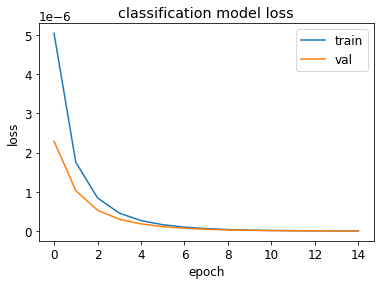

TMAX
skipping TMAX
Tmax-3
skipping Tmax-3
days_past
skipping days_past
cfs_cheesman_res
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_cheesman_res_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 1s 11ms/step - loss: 3.8194e-06 - val_loss: 1.6946e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.2737e-06 - val_loss: 7.3256e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 5.5711e-07 - val_loss: 3.2802e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 2.5068e-07 - val_loss: 1.4994e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 1.1591e-07 - val_loss: 7.0774e-08
Epoch 6/15
90/90 [==============================] - 1s 10ms/step -

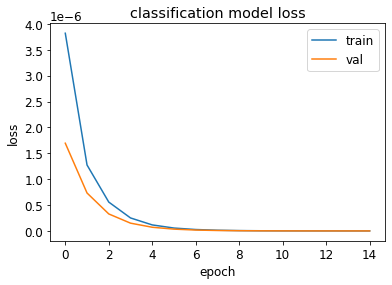

cfs_homestake_pipeline
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_homestake_pipeline_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 1s 11ms/step - loss: 3.0384e-06 - val_loss: 1.4703e-06
Epoch 2/15
90/90 [==============================] - 1s 9ms/step - loss: 1.0693e-06 - val_loss: 6.1843e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 4.2913e-07 - val_loss: 2.3950e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 1.6236e-07 - val_loss: 9.0491e-08
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 6.1747e-08 - val_loss: 3.4945e-08
Epoch 6/15
90/90 [==============================] - 1s 10ms/step - loss: 2.4281e-08 - val_loss: 1.4195e-08
Epoch 7/15
90/90 [

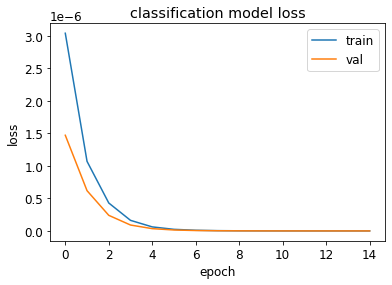

cfs_above_spinney
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_above_spinney_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 1s 12ms/step - loss: 5.4658e-06 - val_loss: 2.2827e-06
Epoch 2/15
90/90 [==============================] - 1s 10ms/step - loss: 1.8926e-06 - val_loss: 1.1673e-06
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 1.0032e-06 - val_loss: 6.3910e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 5.6628e-07 - val_loss: 3.7676e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 3.4021e-07 - val_loss: 2.3517e-07
Epoch 6/15
90/90 [==============================] - 1s 11ms/step - loss: 2.1404e-07 - val_loss: 1.4983e-07
Epoch 7/15
90/90 [=========

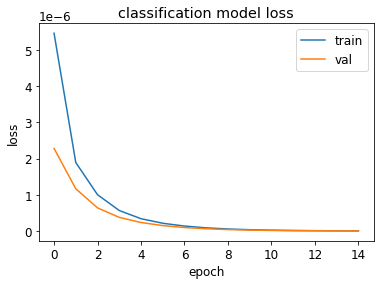

cfs_11mile_outflow
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_11mile_outflow_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 12ms/step - loss: 3.8524e-06 - val_loss: 1.7398e-06
Epoch 2/15
90/90 [==============================] - 1s 11ms/step - loss: 1.3700e-06 - val_loss: 8.4192e-07
Epoch 3/15
90/90 [==============================] - 1s 10ms/step - loss: 6.6336e-07 - val_loss: 4.0883e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 3.2787e-07 - val_loss: 2.0657e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 1.6976e-07 - val_loss: 1.1081e-07
Epoch 6/15
90/90 [==============================] - 1s 10ms/step - loss: 9.2938e-08 - val_loss: 6.2084e-08
Epoch 7/15
90/90 [======

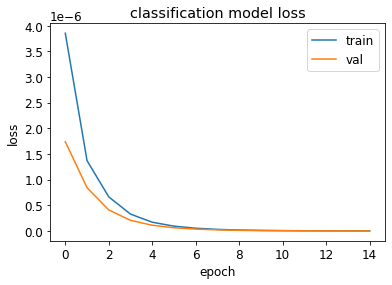

cfs_11mileinflow
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_11mileinflow_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 3s 14ms/step - loss: 5.3019e-06 - val_loss: 1.9760e-06
Epoch 2/15
90/90 [==============================] - 1s 8ms/step - loss: 1.5937e-06 - val_loss: 9.3915e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 7.8248e-07 - val_loss: 4.8486e-07
Epoch 4/15
90/90 [==============================] - 1s 9ms/step - loss: 4.2232e-07 - val_loss: 2.7600e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 2.4830e-07 - val_loss: 1.7055e-07
Epoch 6/15
90/90 [==============================] - 1s 10ms/step - loss: 1.5567e-07 - val_loss: 1.1004e-07
Epoch 7/15
90/90 [============

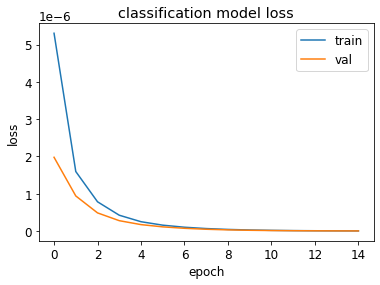

cfs_middle_fork_prince
skipping cfs_middle_fork_prince
cfs_SOUTH_FORK
skipping cfs_SOUTH_FORK
cfs_TARRYALL_BORDEN
90 epoch_steps
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
using train future weights for gauge:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
training  cfs_TARRYALL_BORDEN_model
epoch_steps 90
Epoch 1/15
90/90 [==============================] - 2s 13ms/step - loss: 4.8671e-06 - val_loss: 2.0916e-06
Epoch 2/15
90/90 [==============================] - 1s 8ms/step - loss: 1.6817e-06 - val_loss: 9.9649e-07
Epoch 3/15
90/90 [==============================] - 1s 9ms/step - loss: 8.1716e-07 - val_loss: 5.0316e-07
Epoch 4/15
90/90 [==============================] - 1s 10ms/step - loss: 4.2419e-07 - val_loss: 2.7236e-07
Epoch 5/15
90/90 [==============================] - 1s 9ms/step - loss: 2.3347e-07 - val_loss: 1.5654e-07
Epoch 6/15
90/90 [==================

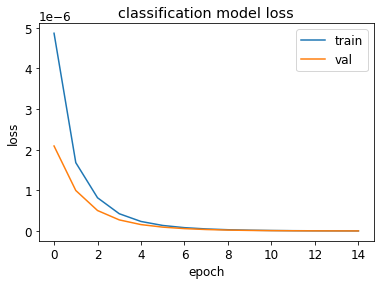

elev_cheesman_res
skipping elev_cheesman_res
elev_CHATFIELD_res
skipping elev_CHATFIELD_res
cfs_below_antero
skipping cfs_below_antero
cfs_Aurora_intake
skipping cfs_Aurora_intake


In [451]:
#train classification model
filter_size = 1
batch_size = 50
reg_value = 1e-6

gauge_individual_models_Classification = {}

PATIENCE = 4
epoch_steps = len(train_x2)//batch_size
rcParams['figure.figsize'] = (6,4)
verbose, epochs = 1, 15

class_train_zero_len = {}

for num, feature in enumerate(features_considered):
    print(feature)
    name_model = feature
    col = num 
    row = 0 

    if num > 4:
        row = 1
        col = num - 5
        
    if num > 9:
        row = 2
        col = num - 10        
        
    if num > 14:
        row = 3
        col = num - 15
        
    if num > 19:
        row = 4
        col = num - 20 
        
    if num > 24:
        row = 5
        col = num - 25
        
    if feature not in features_modeled:
        print('skipping', feature)
        continue

    epoch_steps = len(train_x2)//batch_size
    print(epoch_steps, 'epoch_steps')

    arr_weight_train = np.zeros(shape=(train_x2.shape[0],28,5,6,1,))
    arr_weight_test = np.zeros(shape=(val_x2.shape[0],28,5,6,1,)) 
    
    arr_weight_train[:,:,col,row,:,] = 1
    arr_weight_test[:,:,col,row,:,] = 1
    
    print('using train future weights for gauge: ',arr_weight_train[0,:,col,row,0,])
    print('using train future weights for gauge: ',arr_weight_test[0,:,col,row,0])
    
    print('training ', f'{feature}_model') 

    persistence_train_list = [(x - np.min(persistence_benefit_train_list2[f'{feature}'])) / (np.max(persistence_benefit_train_list2[f'{feature}']) - np.min(persistence_benefit_train_list2[f'{feature}']))-.0001 for x in persistence_benefit_train_list2[f'{feature}']]
    persistence_train_list = np.array(persistence_train_list)
    persistence_val_list = [(x - np.min(persistence_benefit_val_list2[f'{feature}'])) / (np.max(persistence_benefit_val_list2[f'{feature}']) - np.min(persistence_benefit_val_list2[f'{feature}']))-.0001 for x in persistence_benefit_val_list2[f'{feature}']]
    persistence_val_list = np.array(persistence_val_list)

    class_train_zero_len[name_model] = len(persistence_train_list)
    
    model_categorical = Conv_Classification(input_shape, 
                            future, past, filter_size, col,row)

    model_categorical.compile(optimizer='adam',
                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False))

    epoch_steps = len(train_x2)//batch_size
    print('epoch_steps', epoch_steps)
    
    early_stopping = EarlyStopping(monitor=('loss'), patience = PATIENCE, 
                                    mode='min', verbose=1, restore_best_weights=True)
    early_stopping_val = EarlyStopping(monitor=('val_loss'), patience = PATIENCE, 
                                        mode='min', verbose=1, restore_best_weights=True)

    history = model_categorical.fit(train_x2, persistence_train_list, epochs=epochs, 
                                    batch_size=batch_size, 
                                    verbose=verbose, steps_per_epoch=epoch_steps,
                                    sample_weight = arr_weight_train,
                                    validation_data=(val_x2, persistence_val_list, arr_weight_test),
                                    shuffle=True, 
                                    callbacks=[early_stopping,early_stopping_val])
    gauge_individual_models_Classification[f'{feature}_model'] = model_categorical

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.title('classification model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()

In [408]:
def create_forecast_classification(dataset, week_number, future, features_considered, past, model):
    test_split = (len(dataset) - (7 * week_number))
    test_data = dataset[test_split - past:test_split]

    future_data = dataset[test_split:test_split+future] 
    true_future = pd.DataFrame(future_data) 
    true_future.columns = features_considered 

    prior_time = dataset[test_split-past-1:test_split-1]
    past_history = pd.DataFrame(prior_time)
    past_history.columns = features_considered 

    test_data = prior_time.values
    input_x1 = test_data.reshape(past,5,6, order='F')
    input_x4 = np.expand_dims(input_x1,axis=-1)
    input_x4 = np.expand_dims(input_x4,axis=0)
    input_x4 = np.expand_dims(input_x4,axis=-1)
        
    input_x5 = np.pad(input_x4,((0,0),(0,future),(0,0),(0,0),(0,0),(0,0)),'edge')
    forecast_week = model.predict(input_x5)
    forecast_class = np.squeeze(forecast_week)

    return forecast_class

In [409]:
def remove_persist_benefits_base(data, data_labels, persistence_benefit_list):
    drop_list = []
    counter = 0
    for number, x in (list(enumerate(data[:,0,0,0,0,0]))):

        if persistence_benefit_list[number] > np.mean(persistence_benefit_list):
            counter += 1
            drop_list.append(number)

    print('dropped', counter)
    datax3 = np.delete(data,[drop_list],0)
    datay3 = np.delete(data_labels,[drop_list],0)
    return datax3, datay3

skipping cfs_conduit26
skipping cfs_conduit20
skipping Tmax-1
skipping Tmax-2
skipping Tmax-4
dropped 1386
dropped 32
train_x3 is  3144 long for  cfs_roberts
val_x3 is  338 long for  cfs_roberts
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
62 epoch_steps
training  cfs_roberts_model
Epoch 1/60
62/62 [==============================] - 20s 125ms/step - loss: 0.0819 - mean_absolute_error: 0.4749 - val_loss: 0.0623 - val_mean_absolute_error: 0.4736
Epoch 2/60
62/62 [==============================] - 6s 98ms/step - loss: 0.0792 - mean_absolute_error: 0.5197 - val_loss: 0.0618 - val_mean_absolute_error: 0.5438
Epoch 3/60
62/62 [==============================] - 6s 96ms/step - loss: 0.0780 - mean_absolute_error: 0.5535 - val_loss: 0.0601 - val_mean_absolute_error: 0.5852
Epoch 4/60
62/62 [==============================] - 7s 114ms/step - loss: 0.0773 - mean_absolute_error: 0.5836 - val_loss: 0.0588 - val_mean_absolu

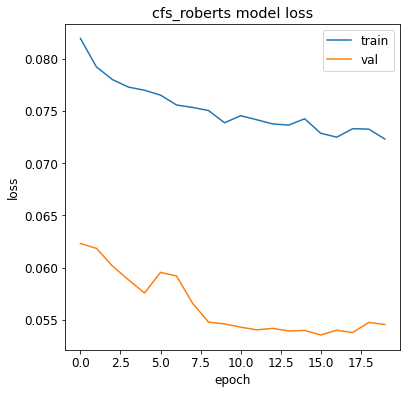

dropped 148
dropped 15
train_x3 is  4382 long for  cfs_deckers
val_x3 is  355 long for  cfs_deckers
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
87 epoch_steps
training  cfs_deckers_model
Epoch 1/60
87/87 [==============================] - 17s 99ms/step - loss: 0.0610 - mean_absolute_error: 0.4770 - val_loss: 0.0416 - val_mean_absolute_error: 0.4319
Epoch 2/60
87/87 [==============================] - 8s 89ms/step - loss: 0.0594 - mean_absolute_error: 0.4893 - val_loss: 0.0409 - val_mean_absolute_error: 0.4647
Epoch 3/60
87/87 [==============================] - 8s 88ms/step - loss: 0.0584 - mean_absolute_error: 0.5059 - val_loss: 0.0397 - val_mean_absolute_error: 0.4902
Epoch 4/60
87/87 [==============================] - 8s 92ms/step - loss: 0.0580 - mean_absolute_error: 0.5308 - val_loss: 0.0396 - val_mean_absolute_error: 0.5362
Epoch 5/60
87/87 [==============================] - 8s 91ms/step - loss: 0.0577 

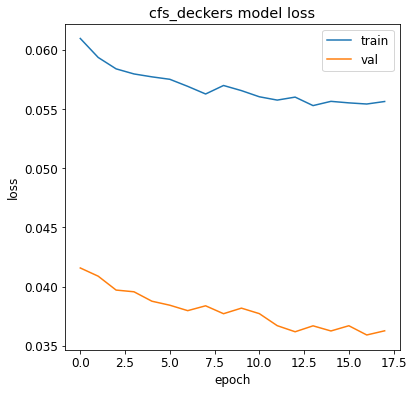

dropped 6
dropped 78
train_x3 is  4524 long for  cfs_grant
val_x3 is  292 long for  cfs_grant
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
90 epoch_steps
training  cfs_grant_model
Epoch 1/60
90/90 [==============================] - 18s 101ms/step - loss: 0.0597 - mean_absolute_error: 0.4540 - val_loss: 0.0543 - val_mean_absolute_error: 0.4000
Epoch 2/60
90/90 [==============================] - 8s 88ms/step - loss: 0.0573 - mean_absolute_error: 0.4635 - val_loss: 0.0539 - val_mean_absolute_error: 0.4146
Epoch 3/60
90/90 [==============================] - 7s 79ms/step - loss: 0.0570 - mean_absolute_error: 0.4708 - val_loss: 0.0542 - val_mean_absolute_error: 0.4223
Epoch 4/60
90/90 [==============================] - 8s 87ms/step - loss: 0.0565 - mean_absolute_error: 0.4824 - val_loss: 0.0522 - val_mean_absolute_error: 0.4370
Epoch 5/60
90/90 [==============================] - 9s 96ms/step - loss: 0.0561 - mean_

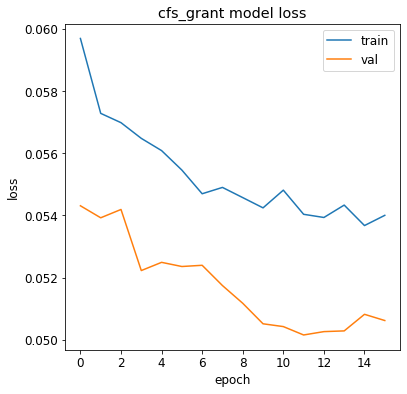

dropped 1235
dropped 69
train_x3 is  3295 long for  cfs_below_brush
val_x3 is  301 long for  cfs_below_brush
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
65 epoch_steps
training  cfs_below_brush_model
Epoch 1/60
65/65 [==============================] - 38s 484ms/step - loss: 0.0644 - mean_absolute_error: 0.4440 - val_loss: 0.0525 - val_mean_absolute_error: 0.4098
Epoch 2/60
65/65 [==============================] - 7s 112ms/step - loss: 0.0604 - mean_absolute_error: 0.4456 - val_loss: 0.0491 - val_mean_absolute_error: 0.4169
Epoch 3/60
65/65 [==============================] - 7s 110ms/step - loss: 0.0607 - mean_absolute_error: 0.4522 - val_loss: 0.0488 - val_mean_absolute_error: 0.4234
Epoch 4/60
65/65 [==============================] - 5s 85ms/step - loss: 0.0598 - mean_absolute_error: 0.4570 - val_loss: 0.0492 - val_mean_absolute_error: 0.4394
Epoch 5/60
65/65 [==============================] - 6s 94ms/step

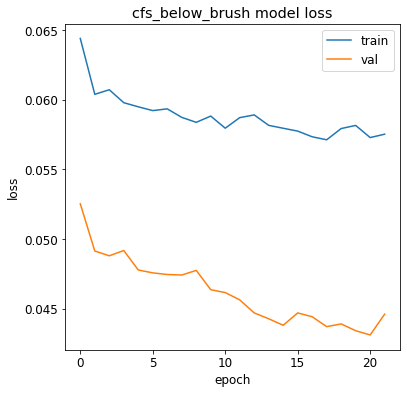

dropped 869
dropped 58
train_x3 is  3661 long for  cfs_below_dillon
val_x3 is  312 long for  cfs_below_dillon
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
73 epoch_steps
training  cfs_below_dillon_model
Epoch 1/60
73/73 [==============================] - 12s 97ms/step - loss: 0.0501 - mean_absolute_error: 0.4732 - val_loss: 0.0366 - val_mean_absolute_error: 0.4239
Epoch 2/60
73/73 [==============================] - 6s 86ms/step - loss: 0.0483 - mean_absolute_error: 0.4986 - val_loss: 0.0381 - val_mean_absolute_error: 0.4587
Epoch 3/60
73/73 [==============================] - 6s 89ms/step - loss: 0.0469 - mean_absolute_error: 0.5139 - val_loss: 0.0381 - val_mean_absolute_error: 0.4784
Epoch 4/60
73/73 [==============================] - 6s 88ms/step - loss: 0.0463 - mean_absolute_error: 0.5301 - val_loss: 0.0381 - val_mean_absolute_error: 0.5035
Epoch 5/60
73/73 [==============================] - 6s 82ms/step 

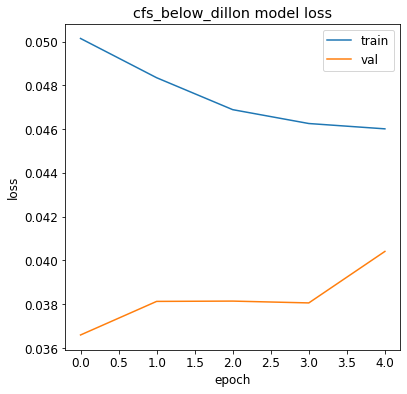

dropped 7
dropped 94
train_x3 is  4523 long for  cfs_waterton
val_x3 is  276 long for  cfs_waterton
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
90 epoch_steps
training  cfs_waterton_model
Epoch 1/60
90/90 [==============================] - 14s 89ms/step - loss: 0.0529 - mean_absolute_error: 0.4720 - val_loss: 0.0379 - val_mean_absolute_error: 0.4222
Epoch 2/60
90/90 [==============================] - 7s 83ms/step - loss: 0.0494 - mean_absolute_error: 0.5201 - val_loss: 0.0337 - val_mean_absolute_error: 0.4701
Epoch 3/60
90/90 [==============================] - 7s 82ms/step - loss: 0.0480 - mean_absolute_error: 0.5477 - val_loss: 0.0327 - val_mean_absolute_error: 0.4917
Epoch 4/60
90/90 [==============================] - 8s 83ms/step - loss: 0.0477 - mean_absolute_error: 0.5669 - val_loss: 0.0333 - val_mean_absolute_error: 0.5195
Epoch 5/60
90/90 [==============================] - 8s 84ms/step - loss: 0.0473

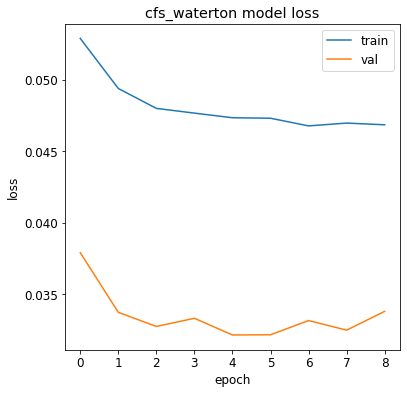

dropped 736
dropped 8
train_x3 is  3794 long for  cfs_bailey
val_x3 is  362 long for  cfs_bailey
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
75 epoch_steps
training  cfs_bailey_model
Epoch 1/60
75/75 [==============================] - 13s 90ms/step - loss: 0.0710 - mean_absolute_error: 0.4693 - val_loss: 0.0577 - val_mean_absolute_error: 0.4016
Epoch 2/60
75/75 [==============================] - 6s 83ms/step - loss: 0.0692 - mean_absolute_error: 0.4834 - val_loss: 0.0539 - val_mean_absolute_error: 0.4152
Epoch 3/60
75/75 [==============================] - 6s 82ms/step - loss: 0.0685 - mean_absolute_error: 0.4950 - val_loss: 0.0522 - val_mean_absolute_error: 0.4283
Epoch 4/60
75/75 [==============================] - 6s 82ms/step - loss: 0.0672 - mean_absolute_error: 0.5056 - val_loss: 0.0528 - val_mean_absolute_error: 0.4448
Epoch 5/60
75/75 [==============================] - 6s 81ms/step - loss: 0.0677 - me

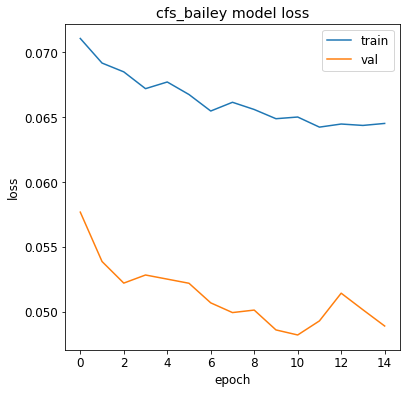

dropped 1719
dropped 46
train_x3 is  2811 long for  cfs_cheesman_inflow
val_x3 is  324 long for  cfs_cheesman_inflow
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
56 epoch_steps
training  cfs_cheesman_inflow_model
Epoch 1/60
56/56 [==============================] - 11s 96ms/step - loss: 0.0757 - mean_absolute_error: 0.4810 - val_loss: 0.0690 - val_mean_absolute_error: 0.3758
Epoch 2/60
56/56 [==============================] - 5s 87ms/step - loss: 0.0730 - mean_absolute_error: 0.4783 - val_loss: 0.0670 - val_mean_absolute_error: 0.3776
Epoch 3/60
56/56 [==============================] - 5s 87ms/step - loss: 0.0715 - mean_absolute_error: 0.4821 - val_loss: 0.0636 - val_mean_absolute_error: 0.3771
Epoch 4/60
56/56 [==============================] - 5s 84ms/step - loss: 0.0710 - mean_absolute_error: 0.4840 - val_loss: 0.0618 - val_mean_absolute_error: 0.3783
Epoch 5/60
56/56 [==============================] - 5s 

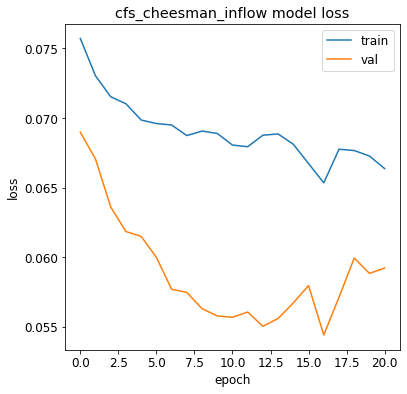

dropped 115
dropped 108
train_x3 is  4415 long for  cfs_above_chatfield
val_x3 is  262 long for  cfs_above_chatfield
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
88 epoch_steps
training  cfs_above_chatfield_model
Epoch 1/60
88/88 [==============================] - 13s 93ms/step - loss: 0.0520 - mean_absolute_error: 0.4651 - val_loss: 0.0344 - val_mean_absolute_error: 0.4815
Epoch 2/60
88/88 [==============================] - 7s 83ms/step - loss: 0.0497 - mean_absolute_error: 0.4963 - val_loss: 0.0350 - val_mean_absolute_error: 0.5167
Epoch 3/60
88/88 [==============================] - 8s 86ms/step - loss: 0.0482 - mean_absolute_error: 0.5134 - val_loss: 0.0357 - val_mean_absolute_error: 0.5293
Epoch 4/60
88/88 [==============================] - 7s 83ms/step - loss: 0.0488 - mean_absolute_error: 0.5190 - val_loss: 0.0350 - val_mean_absolute_error: 0.5323
Epoch 5/60
88/88 [==============================] - 7s 

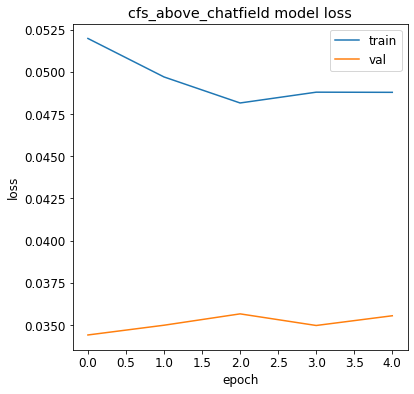

dropped 82
dropped 82
train_x3 is  4448 long for  cfs_below_strontia
val_x3 is  288 long for  cfs_below_strontia
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
88 epoch_steps
training  cfs_below_strontia_model
Epoch 1/60
88/88 [==============================] - 13s 89ms/step - loss: 0.0577 - mean_absolute_error: 0.4734 - val_loss: 0.0456 - val_mean_absolute_error: 0.4413
Epoch 2/60
88/88 [==============================] - 7s 83ms/step - loss: 0.0553 - mean_absolute_error: 0.4948 - val_loss: 0.0460 - val_mean_absolute_error: 0.4464
Epoch 3/60
88/88 [==============================] - 7s 83ms/step - loss: 0.0550 - mean_absolute_error: 0.5087 - val_loss: 0.0439 - val_mean_absolute_error: 0.4542
Epoch 4/60
88/88 [==============================] - 7s 85ms/step - loss: 0.0543 - mean_absolute_error: 0.5198 - val_loss: 0.0441 - val_mean_absolute_error: 0.4599
Epoch 5/60
88/88 [==============================] - 8s 86ms/

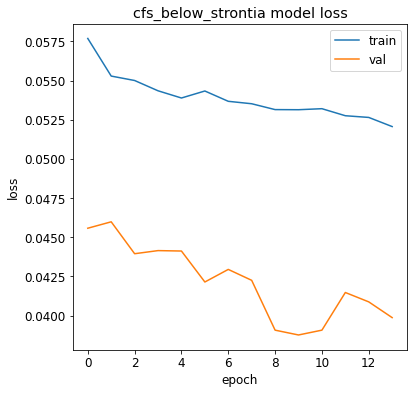

skipping TMAX
skipping Tmax-3
skipping days_past
dropped 1791
dropped 140
train_x3 is  2739 long for  cfs_cheesman_res
val_x3 is  230 long for  cfs_cheesman_res
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
54 epoch_steps
training  cfs_cheesman_res_model
Epoch 1/60
54/54 [==============================] - 11s 99ms/step - loss: 0.0450 - mean_absolute_error: 0.4507 - val_loss: 0.0320 - val_mean_absolute_error: 0.4417
Epoch 2/60
54/54 [==============================] - 5s 89ms/step - loss: 0.0436 - mean_absolute_error: 0.4653 - val_loss: 0.0359 - val_mean_absolute_error: 0.4501
Epoch 3/60
54/54 [==============================] - 5s 89ms/step - loss: 0.0426 - mean_absolute_error: 0.4744 - val_loss: 0.0341 - val_mean_absolute_error: 0.4575
Epoch 4/60
54/54 [==============================] - 4s 81ms/step - loss: 0.0426 - mean_absolute_error: 0.4808 - val_loss: 0.0349 - val_mean_absolute_error: 0.4642
Epoch 5/60
54/

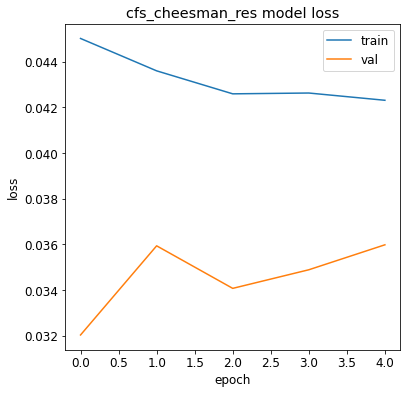

dropped 1647
dropped 140
train_x3 is  2883 long for  cfs_homestake_pipeline
val_x3 is  230 long for  cfs_homestake_pipeline
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
57 epoch_steps
training  cfs_homestake_pipeline_model
Epoch 1/60
57/57 [==============================] - 10s 92ms/step - loss: 0.0590 - mean_absolute_error: 0.4672 - val_loss: 0.0604 - val_mean_absolute_error: 0.4061
Epoch 2/60
57/57 [==============================] - 5s 87ms/step - loss: 0.0561 - mean_absolute_error: 0.4857 - val_loss: 0.0599 - val_mean_absolute_error: 0.4205
Epoch 3/60
57/57 [==============================] - 5s 85ms/step - loss: 0.0554 - mean_absolute_error: 0.5054 - val_loss: 0.0620 - val_mean_absolute_error: 0.4405
Epoch 4/60
57/57 [==============================] - 5s 82ms/step - loss: 0.0558 - mean_absolute_error: 0.5294 - val_loss: 0.0568 - val_mean_absolute_error: 0.4597
Epoch 5/60
57/57 [===========================

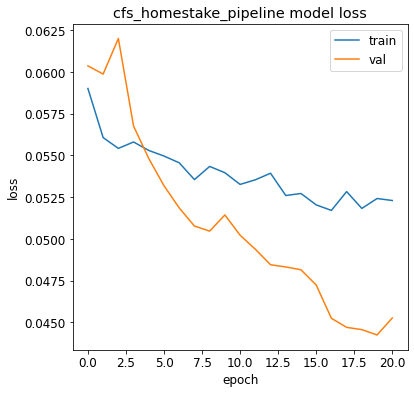

dropped 384
dropped 114
train_x3 is  4146 long for  cfs_above_spinney
val_x3 is  256 long for  cfs_above_spinney
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
82 epoch_steps
training  cfs_above_spinney_model
Epoch 1/60
82/82 [==============================] - 15s 107ms/step - loss: 0.0482 - mean_absolute_error: 0.4991 - val_loss: 0.0442 - val_mean_absolute_error: 0.4721
Epoch 2/60
82/82 [==============================] - 8s 95ms/step - loss: 0.0441 - mean_absolute_error: 0.5442 - val_loss: 0.0436 - val_mean_absolute_error: 0.5409
Epoch 3/60
82/82 [==============================] - 8s 103ms/step - loss: 0.0438 - mean_absolute_error: 0.5809 - val_loss: 0.0425 - val_mean_absolute_error: 0.5851
Epoch 4/60
82/82 [==============================] - 9s 104ms/step - loss: 0.0426 - mean_absolute_error: 0.6116 - val_loss: 0.0420 - val_mean_absolute_error: 0.6105
Epoch 5/60
82/82 [==============================] - 10s 11

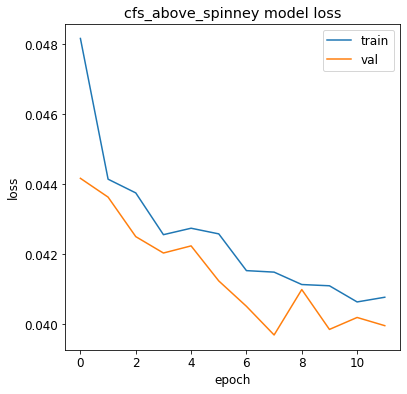

dropped 180
dropped 103
train_x3 is  4350 long for  cfs_11mile_outflow
val_x3 is  267 long for  cfs_11mile_outflow
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
87 epoch_steps
training  cfs_11mile_outflow_model
Epoch 1/60
87/87 [==============================] - 10s 78ms/step - loss: 0.0483 - mean_absolute_error: 0.4669 - val_loss: 0.0315 - val_mean_absolute_error: 0.4262
Epoch 2/60
87/87 [==============================] - 6s 74ms/step - loss: 0.0466 - mean_absolute_error: 0.4844 - val_loss: 0.0313 - val_mean_absolute_error: 0.4591
Epoch 3/60
87/87 [==============================] - 7s 78ms/step - loss: 0.0453 - mean_absolute_error: 0.4972 - val_loss: 0.0311 - val_mean_absolute_error: 0.4784
Epoch 4/60
87/87 [==============================] - 7s 81ms/step - loss: 0.0448 - mean_absolute_error: 0.5030 - val_loss: 0.0308 - val_mean_absolute_error: 0.4834
Epoch 5/60
87/87 [==============================] - 7s 78m

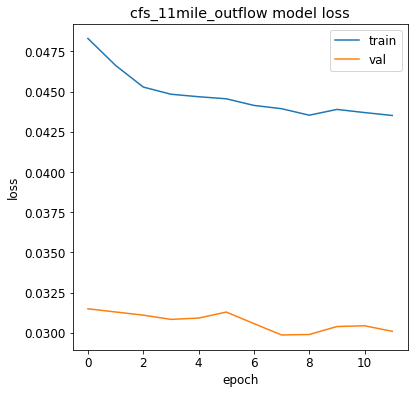

dropped 252
dropped 6
train_x3 is  4278 long for  cfs_11mileinflow
val_x3 is  364 long for  cfs_11mileinflow
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
85 epoch_steps
training  cfs_11mileinflow_model
Epoch 1/60
85/85 [==============================] - 15s 112ms/step - loss: 0.0598 - mean_absolute_error: 0.4586 - val_loss: 0.0412 - val_mean_absolute_error: 0.4072
Epoch 2/60
85/85 [==============================] - 9s 101ms/step - loss: 0.0586 - mean_absolute_error: 0.4696 - val_loss: 0.0438 - val_mean_absolute_error: 0.4106
Epoch 3/60
85/85 [==============================] - 8s 92ms/step - loss: 0.0582 - mean_absolute_error: 0.4732 - val_loss: 0.0441 - val_mean_absolute_error: 0.4153
Epoch 4/60
85/85 [==============================] - 8s 89ms/step - loss: 0.0582 - mean_absolute_error: 0.4777 - val_loss: 0.0447 - val_mean_absolute_error: 0.4211
Epoch 5/60
85/85 [==============================] - 7s 86ms/step

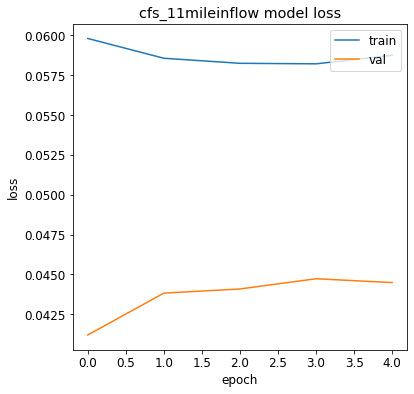

skipping cfs_middle_fork_prince
skipping cfs_SOUTH_FORK
dropped 1047
dropped 47
train_x3 is  3483 long for  cfs_TARRYALL_BORDEN
val_x3 is  323 long for  cfs_TARRYALL_BORDEN
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
using train future weights for gauge:  [7. 6. 5. 4. 3. 2. 1.]
69 epoch_steps
training  cfs_TARRYALL_BORDEN_model
Epoch 1/60
69/69 [==============================] - 12s 96ms/step - loss: 0.0581 - mean_absolute_error: 0.5079 - val_loss: 0.0397 - val_mean_absolute_error: 0.4379
Epoch 2/60
69/69 [==============================] - 6s 92ms/step - loss: 0.0560 - mean_absolute_error: 0.5548 - val_loss: 0.0403 - val_mean_absolute_error: 0.4952
Epoch 3/60
69/69 [==============================] - 6s 90ms/step - loss: 0.0549 - mean_absolute_error: 0.5925 - val_loss: 0.0404 - val_mean_absolute_error: 0.5185
Epoch 4/60
69/69 [==============================] - 6s 88ms/step - loss: 0.0540 - mean_absolute_error: 0.6149 - val_loss: 0.0434 - val_mean_absolute_error: 0.5635

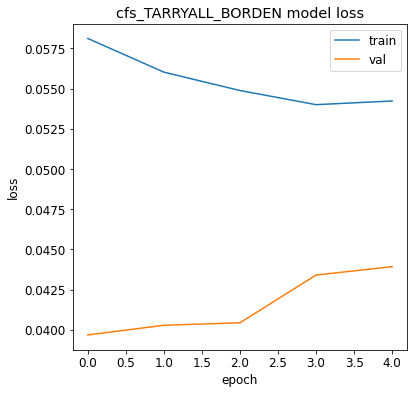

skipping elev_cheesman_res
skipping elev_CHATFIELD_res
skipping cfs_below_antero
skipping cfs_Aurora_intake


In [470]:
# Short models using non-persistent-benefit data
filter_size = 1
train_lens_short_model = {}
val_lens_short_model = {}
rcParams['figure.figsize'] = (6,6)

gauge_individual_models_2DLSTM_short = {}
weights_from_base = base_weights_2DLSTM 

PATIENCE = 5
verbose, epochs = 1, 60
counter = 1
persist_fraction = {}
reg_value = 1e-6

for num, feature in enumerate(features_considered):
    col = num 
    row = 0 

    if num > 4:
        row = 1
        col = num - 5
        
    if num > 9:
        row = 2
        col = num - 10        
        
    if num > 14:
        row = 3
        col = num - 15
        
    if num > 19:
        row = 4
        col = num - 20 
        
    if num > 24:
        row = 5
        col = num - 25

    if feature not in features_modeled:
        print('skipping', feature)
        continue

    counter += 1
    train_x3, train_y3 = remove_persist_benefits_base(train_x2, train_y2, 
                                                        persistence_benefit_train_list2[f'{feature}'])
    val_x3, val_y3 = remove_persist_benefits_base(val_x2, val_y2, 
                                                    persistence_benefit_val_list2[f'{feature}'])

    print('train_x3 is ', len(train_x3), 'long for ', feature)
    print('val_x3 is ', len(val_x3), 'long for ', feature)

    arr_weight_train = np.zeros(shape=(train_x3.shape[0],7,5,6,1,1))
    arr_weight_test = np.zeros(shape=(val_x3.shape[0],7,5,6,1,1)) 
    
    for day in range(future):
        arr_weight_train[:,day,col,row,:,:] = 7-(day)
        arr_weight_test[:,day,col,row,:,:] = 7-(day)
     
    print('using train future weights for gauge: ', arr_weight_train[0,:,col,row,0,0])
    print('using train future weights for gauge: ', arr_weight_test[0,:,col,row,0,0])

    persist_fraction[feature] = len(train_x3)
    
    batch_size = 50
    epoch_steps = len(train_x3)//batch_size
    print(epoch_steps, 'epoch_steps')

    print('training ', f'{feature}_model') 

    model_individual = LSTM2D_Model(input_shape, reg_value)
 
    model_individual.set_weights(weights_from_base)

    model_individual.compile(optimizer, metrics=[metrics.mae], loss=custom_loss_MAE)

    history = model_individual.fit(train_x3, train_y3, epochs = epochs, 
                                batch_size = batch_size, 
                                verbose = verbose, steps_per_epoch = epoch_steps,
                                sample_weight = arr_weight_train,  
                                validation_data = (val_x3, val_y3, arr_weight_test),
                                shuffle = False,
                                callbacks = [early_stopping, early_stopping_val])

    gauge_individual_models_2DLSTM_short[f'{feature}_model'] = model_individual

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{feature} model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()

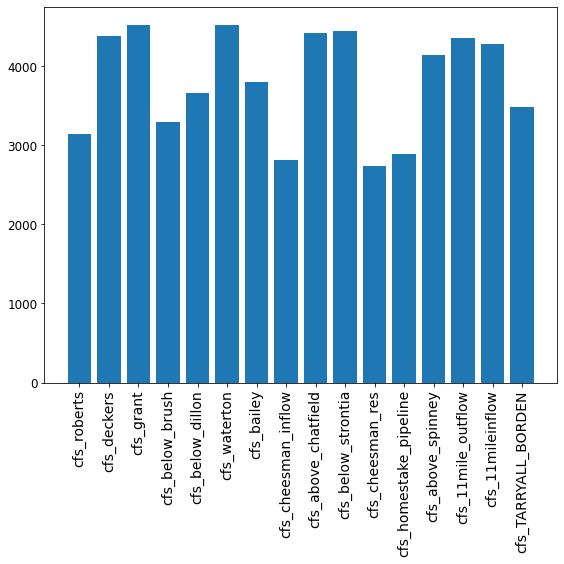

In [471]:
rcParams['figure.figsize'] = (8,8)

plt.xticks(fontsize=14, rotation=90)
plt.bar(persist_fraction.keys(), persist_fraction.values())
plt.tight_layout()
plt.savefig('fraction_persist_true_manuscript_final.png')

In [472]:
def plot_error(future_points, predicted_points, history_points, persistence):

    pred_diff = (np.array(future_points) - np.array(predicted_points))
    numerator = np.sum(pred_diff * pred_diff)
    past_var = (np.array(predicted_points) - np.mean(np.array(history_points))) 
    denom = np.sum(past_var * past_var)
    Nash = (1 - (numerator/denom))
    
    abs_pred_diff = np.sum(abs(pred_diff))
    old_denom = np.sum(abs(pred_diff-np.mean(history_points[0][0:7]))+abs(past_var))
    Willmott =  (1 - (abs_pred_diff/(old_denom)))
    
    persistence_diff = (np.array(future_points) - np.array(persistence))
    persistence_numerator = (np.sum(persistence_diff * persistence_diff)) 
    persistence_Nash = (1 - ((persistence_numerator)/(denom)))

    abs_persistence_diff = np.sum(abs(persistence_diff))
    persistence_Willmott = (1 - (abs_persistence_diff/(old_denom)))

    return Nash, Willmott, persistence_Nash, persistence_Willmott

In [473]:
def create_forecast(dataset, week_number, future, features_considered, past, model):
    test_split = (len(dataset) - (7 * week_number))
    test_data = dataset[test_split - past:test_split]

    future_data = dataset[test_split:test_split+future] 
    true_future = pd.DataFrame(future_data) 
    true_future.columns = features_considered 

    prior_time = dataset[test_split-past-1:test_split-1]
    past_history = pd.DataFrame(prior_time)
    past_history.columns = features_considered 

    test_data = prior_time.values
    input_x1 = test_data.reshape(past,5,6, order='F')
    input_x4 = np.expand_dims(input_x1,axis=-1)
    input_x4 = np.expand_dims(input_x4,axis=0)
    input_x4 = np.expand_dims(input_x4,axis=-1)
        
    input_x5 = np.pad(input_x4,((0,0),(0,future),(0,0),(0,0),(0,0),(0,0)),'edge')
    forecast_weekly = model(input_x5, training=False)
    forecast_weekly=forecast_weekly[0,0:future,:,:,0]
    forecast_weekly = np.squeeze(np.array(forecast_weekly))

    forecast_weekly = forecast_weekly.transpose([1,2,0])
    forecast_week = forecast_weekly.reshape((5 * 6),future, order='F')
    forecast_week = forecast_week.transpose([1,0])
    forecast_week = pd.DataFrame(forecast_week)
    forecast_week.columns = features_considered 
    return past_history, true_future, forecast_week

In [476]:
def out_iqr(s, low = 25, k = 1):
    q25, q75 = np.percentile(s, low), np.percentile(s, 75)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    return lower, upper

In [477]:
def pad_dict_list(dict_list, pad_value):
    lmax = 0
    for lname in dict_list.keys():
        lmax = max(lmax, len(dict_list[lname]))
    for lname in dict_list.keys():
        ll = len(dict_list[lname])
        if  ll < lmax:
            dict_list[lname] += [pad_value] * (lmax - ll)
    return dict_list

In [478]:
def assemble_errors(name_model,stds_train_dict,means_train_dict,
                    true_future,forecast_week,past_history):
    future_points = []       
    predicted_points = []
    history_points = []

    tot_error = 0
    future_points.append((true_future * stds_train_dict[name_model]) + 
                         means_train_dict[name_model])
    predicted_points.append((forecast_week[name_model] * stds_train_dict[name_model]) + 
                            means_train_dict[name_model])
    history_points.append((past_history[name_model] * stds_train_dict[name_model]) + 
                          means_train_dict[name_model])

    gauge_error = abs(np.array(future_points) - np.array(predicted_points))   
    tot_error = np.sum(gauge_error[0,:])

    persistence = np.array(history_points[0][-1])
    persistence = persistence.repeat(future)
    persistence_tot_error = np.sum(abs(np.subtract(np.array(future_points), persistence)))

    Nash, Willmott, persistence_Nash, persistence_Willmott = plot_error(
            future_points, predicted_points, history_points, persistence)

    return Nash, Willmott, persistence_Nash, persistence_Willmott, tot_error, \
        future_points, predicted_points, history_points, persistence_tot_error

In [479]:
# box plots

dataset=season_selected[:]
start_week = 145
out_week = 178
total_persist, total_modeled = 0, 0
Week_total_error_combo,Nash_combo,Willmott_combo,ratio_combo,tot7_combo,max_Willmott_list,median_Willmott_list,max_persistence_Willmott_list,median_persistence_Willmott_list = ({} for i in range(9))
persist_counts = {}

for gauge_num, gauge in enumerate(gauge_individual_models_2DLSTM_short):
    
    if gauge not in features_modeled:
        continue

    name_model = str(gauge).replace('_model','')
    persist_gauge_total = 0
    print('name_model', name_model)
    for week_number in range(out_week, start_week, -1):

        past_history, true_future, forecast_week = create_forecast(dataset,
                   week_number, future, features_considered,
                   past,  gauge_individual_models_2DLSTM_short[f'{gauge}']
        )
        true_future_model = true_future[f'{name_model}']
        print('for week:',(str(true_future.iloc[1:2].index[0])))
        print('true_future_model is', list(true_future_model.reset_index(drop=True)[0:4]))
        forecast_class = create_forecast_classification(
            dataset, week_number, future, features_considered, past,
            gauge_individual_models_Classification[f'{gauge}'])
        print('forecast_class is', forecast_class)
        
        if max(past_history.index.year)-min(past_history.index.year) > 0:
            print('for week:',(str(true_future.iloc[1:2].index[0])),
                  'drop double year', max(past_history.index.year),
                  min(past_history.index.year))
            continue
            
        Nash, Willmott, persistence_Nash, persistence_Willmott,tot_error, \
            future_points, predicted_points, history_points, persistence_tot_error = \
            assemble_errors(name_model, stds_train_dict, means_train_dict,
                            true_future_model.reset_index(drop=True), forecast_week, past_history)
        
        if (forecast_class > .5):
            persist_gauge_total += 1
            total_persist_base += 1

            try:
                Willmott_combo[f'{gauge}_Willmott_best'].append(persistence_Willmott)
            except:
                try:
                    Willmott_combo[f'{gauge}_Willmott_best'] = [persistence_Willmott]
                except:
                    print('oops: ', persistence_Willmott)
            
            try:
                Nash_combo[f'{gauge}_Nash_best'].append(persistence_Nash)
            except:
                try:
                    Nash_combo[f'{gauge}_Nash_best'] = [persistence_Nash]
                except:
                    print('oops: ', persistence_Nash)
                    
            try:
                Week_total_error_combo[f'{gauge}_tot_error_best'].append(persistence_tot_error)
            except:
                try:
                    Week_total_error_combo[f'{gauge}_tot_error_best'] = [persistence_tot_error]
                except:
                    print('oops: ', persistence_tot_error)

            print('PERSISTENCE', (str(true_future.iloc[1:2].index[0])))

        else:
            print('NOT PERSISTENCE forecast_class <.5', forecast_class)
            total_modeled += 1               
     
            try:
                Willmott_combo[f'{gauge}_Willmott_best'].append(Willmott)
            except:
                try:
                    Willmott_combo[f'{gauge}_Willmott_best'] = [Willmott]
                except:
                    print('oops: ', Willmott)
            try:
                Nash_combo[f'{gauge}_Nash_best'].append(Nash)
            except:
                try:
                    Nash_combo[f'{gauge}_Nash_best'] = [Nash]
                except:
                    print('oops: ', Nash)
            try:
                Week_total_error_combo[f'{gauge}_tot_error_best'].append(tot_error)
            except:
                try:
                    Week_total_error_combo[f'{gauge}_tot_error_best'] = [tot_error]
                except:
                    print('oops: ', tot_error)
                   
    persist_counts[name_model] = out_week-start_week-persist_gauge_total
    print('persist_gauge_total ', persist_gauge_total, name_model,
         'out of ', out_week-start_week)

print('total_persist_base is ', total_persist)
print('total_modeled_base  ', total_modeled)
print(persist_counts)

name_model cfs_roberts
for week: 2015-08-10 00:00:00
true_future_model is [-0.8806555850132286, -0.8806555850132286, -0.8806555850132286, -0.8806555850132286]
forecast_class is 0.5003173
PERSISTENCE 2015-08-10 00:00:00
for week: 2015-08-17 00:00:00
true_future_model is [-0.8806555850132286, -0.8806555850132286, -0.8806555850132286, -0.6423017628479332]
forecast_class is 0.49959803
NOT PERSISTENCE forecast_class <.5 0.49959803
for week: 2015-08-24 00:00:00
true_future_model is [-0.23369521056456954, -0.23369521056456954, -0.23369521056456954, -0.09749302647011499]
forecast_class is 0.49967074
NOT PERSISTENCE forecast_class <.5 0.49967074
for week: 2015-08-31 00:00:00
true_future_model is [1.2304782684508166, 1.2134529954390099, 0.9665865367678111, 0.8133590796615497]
forecast_class is 0.5000411
PERSISTENCE 2015-08-31 00:00:00
for week: 2015-09-07 00:00:00
true_future_model is [1.3156046335098508, 1.3156046335098508, 1.111301357368169, 0.6686442590611917]
forecast_class is 0.5007044
PERS

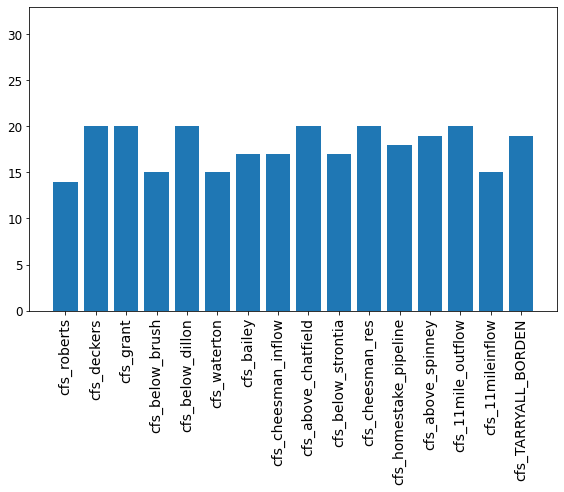

In [480]:
save_name=str('Manuscript_version_Full_model_final')
rcParams['figure.figsize'] = (8,7)

plt.xticks(fontsize=14, rotation=90)
plt.ylim([0,33])
plt.bar(persist_counts.keys(), persist_counts.values())
plt.tight_layout()
plt.savefig(f'PersistCounts_{save_name}.png')

In [504]:
for x in Willmott_combo:
    print(np.median(Willmott_combo[x]))

0.8372040144019659
0.8592277275621107
0.8270743588189099
0.8813998654425992
0.9470788361400632
0.8926760759353428
0.8684083992484569
0.8983811855562863
0.8709949669550886
0.7905847371768645
0.7053484251882789
0.7669130752031769
0.8524542147272592
0.8846930871391447
0.8816985979419393
0.882550936423775


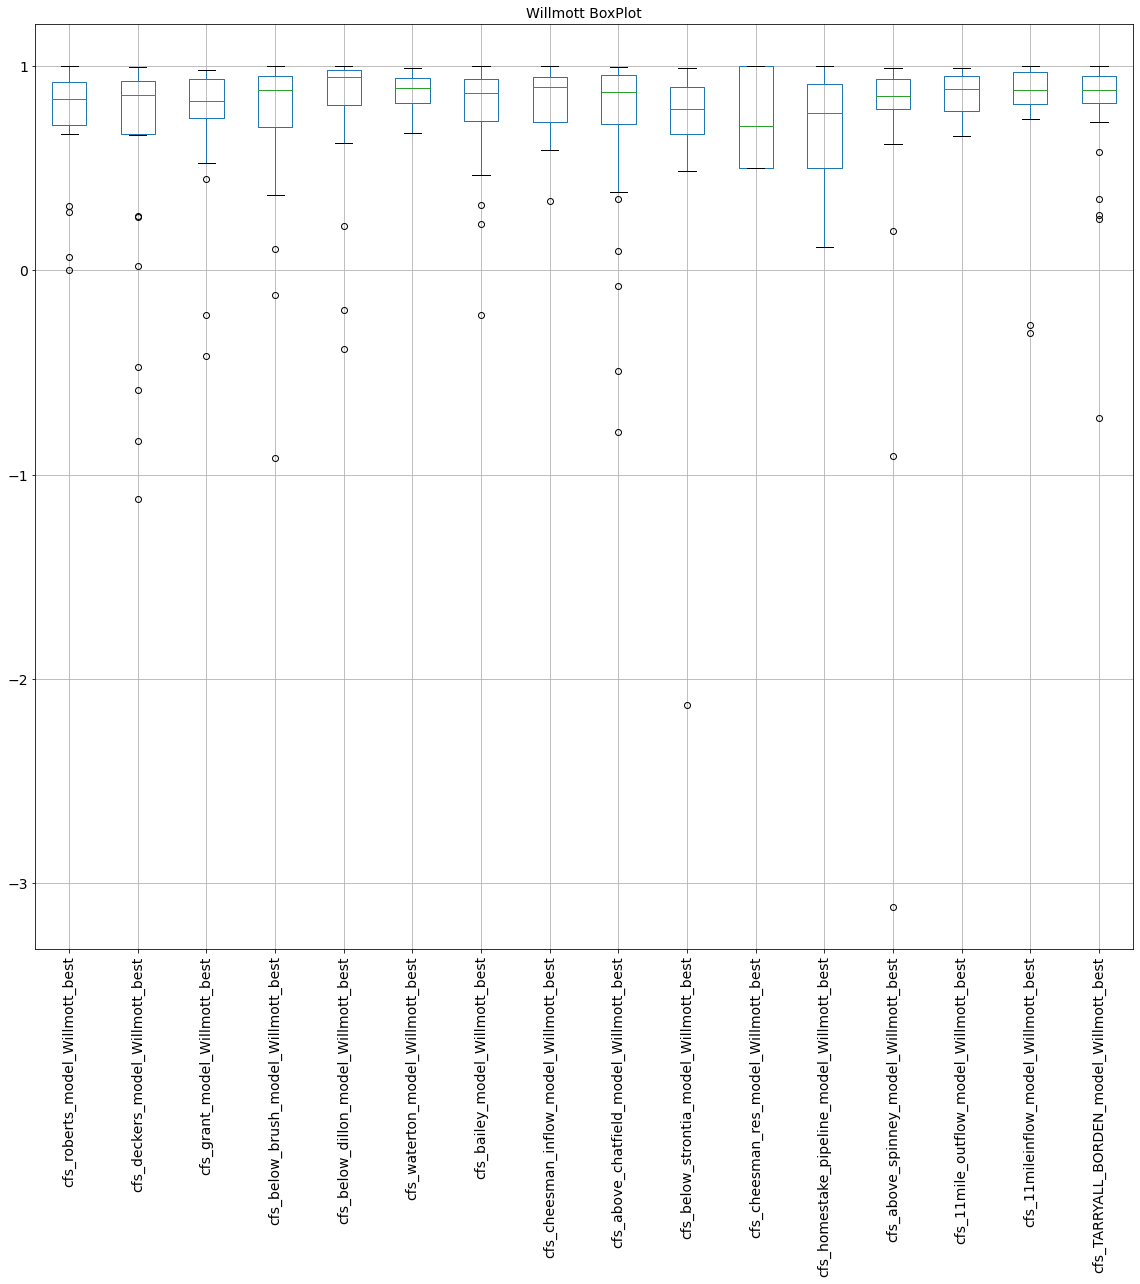

In [481]:
filled_error_list = pad_dict_list(Willmott_combo, float("nan"))
error_df = pd.DataFrame.from_dict(filled_error_list)

rcParams['figure.figsize'] = 16,18
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Willmott BoxPlot", fontsize=14)
ax = error_df.boxplot(rot = 90)

plt.tight_layout()
plt.savefig(f'WillmottBoxPlot_{save_name}.png')

In [506]:
for x in Nash_combo:
    print(np.median(Nash_combo[x]))

0.15342644096929325
0.06335383637250075
0.10637805260547029
0.33443899333982613
0.8552832873607827
-0.2691789805642746
0.3255906175733814
-0.22766483203151522
0.2601649265650434
-1.758792711076016
0.43161400410239786
-0.05357921065789717
0.37766243221718004
0.4407290813354971
0.32202216909644116
0.3433288447409762


cfs_roberts_model_Nash_best 5
cfs_deckers_model_Nash_best 10
cfs_grant_model_Nash_best 14
cfs_below_brush_model_Nash_best 7
cfs_below_dillon_model_Nash_best 8
cfs_waterton_model_Nash_best 10
cfs_bailey_model_Nash_best 10
cfs_cheesman_inflow_model_Nash_best 4
cfs_above_chatfield_model_Nash_best 14
cfs_below_strontia_model_Nash_best 11
cfs_cheesman_res_model_Nash_best 0
cfs_homestake_pipeline_model_Nash_best 12
cfs_above_spinney_model_Nash_best 5
cfs_11mile_outflow_model_Nash_best 6
cfs_11mileinflow_model_Nash_best 12
cfs_TARRYALL_BORDEN_model_Nash_best 5


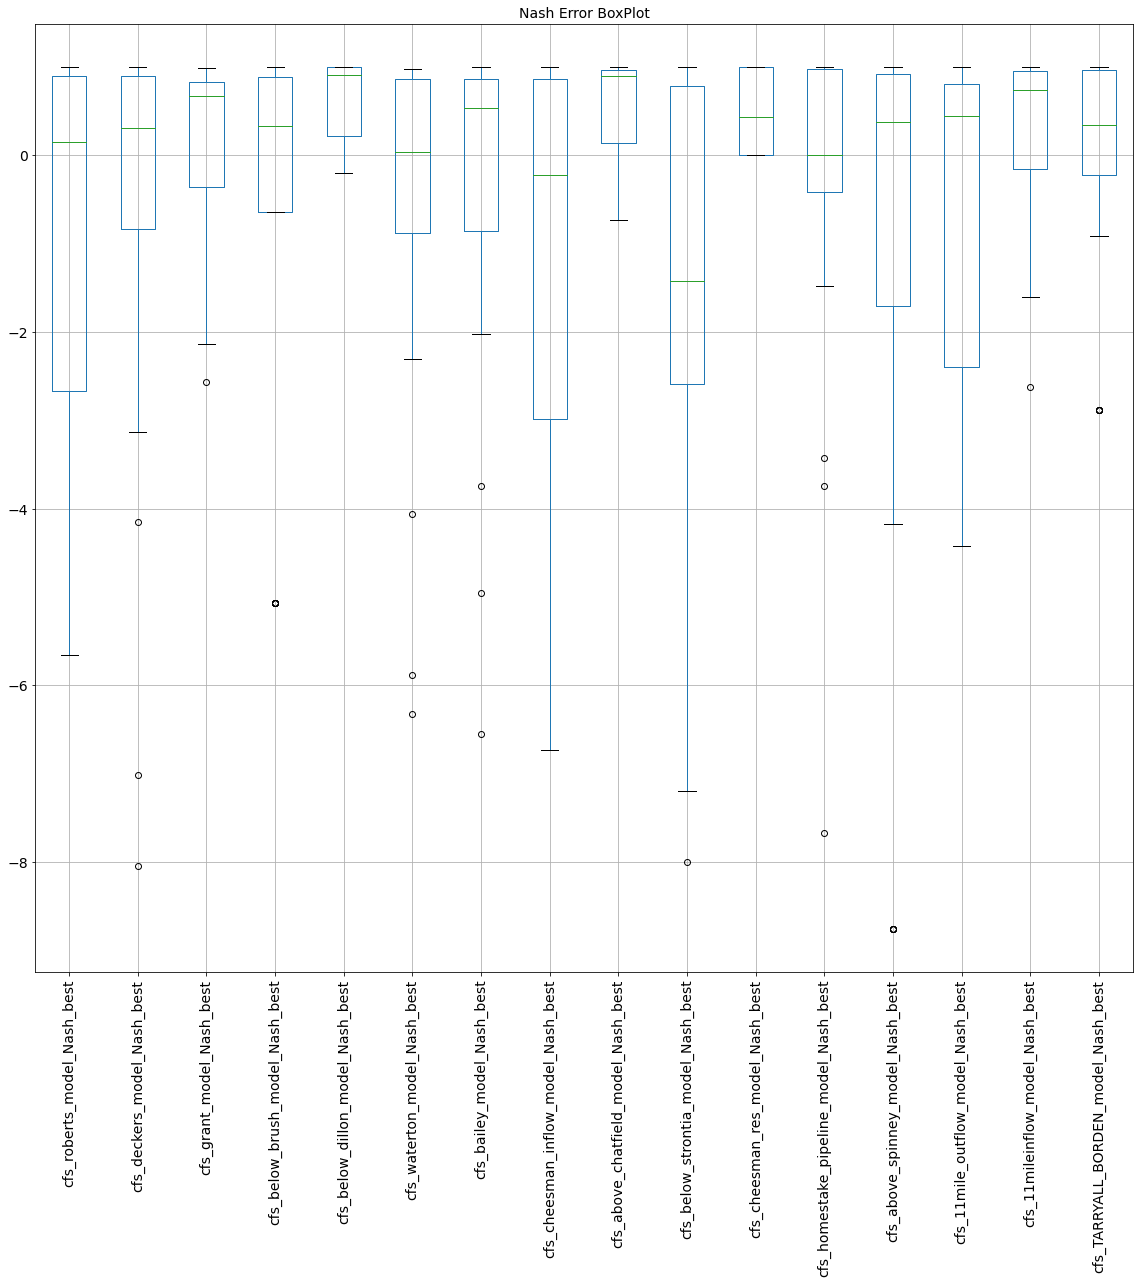

In [482]:
filled_error_list = pad_dict_list(Nash_combo, float("nan"))
error_df = pd.DataFrame.from_dict(filled_error_list)

for col in error_df.columns:
    replaced_outliers = 0
    filler = np.mean(error_df[col])
    IQR_cutoff = out_iqr(error_df[col], low = 25, k = 1)

    for count, x in enumerate(error_df[col]):
        
        if error_df[col][count] > IQR_cutoff[1]:
            error_df[col][count] = filler
            replaced_outliers += 1
            
        if error_df[col][count] < IQR_cutoff[0]:
            error_df[col][count] = filler
            replaced_outliers += 1
            
        if error_df[col][count] < -10:
            error_df[col][count] = float('nan')
            replaced_outliers += 1

    print(col, replaced_outliers)

rcParams['figure.figsize'] = 16,18
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Nash Error BoxPlot", fontsize=14)
ax = error_df.boxplot(rot = 90)

plt.tight_layout()
plt.savefig(f'NashBoxPlot_{save_name}.png')

In [503]:
for x in Week_total_error_combo:
    print(np.median(Week_total_error_combo[x]))

266.51136779785156
350.87463760375977
323.0
349.5
152.1476707458496
396.5
290.77183544515344
211.0273895263672
114.11666107177734
264.3764228820801
4.007149696350098
56.90246631622314
126.54665184020996
132.11350631713867
156.0
68.05292500305175


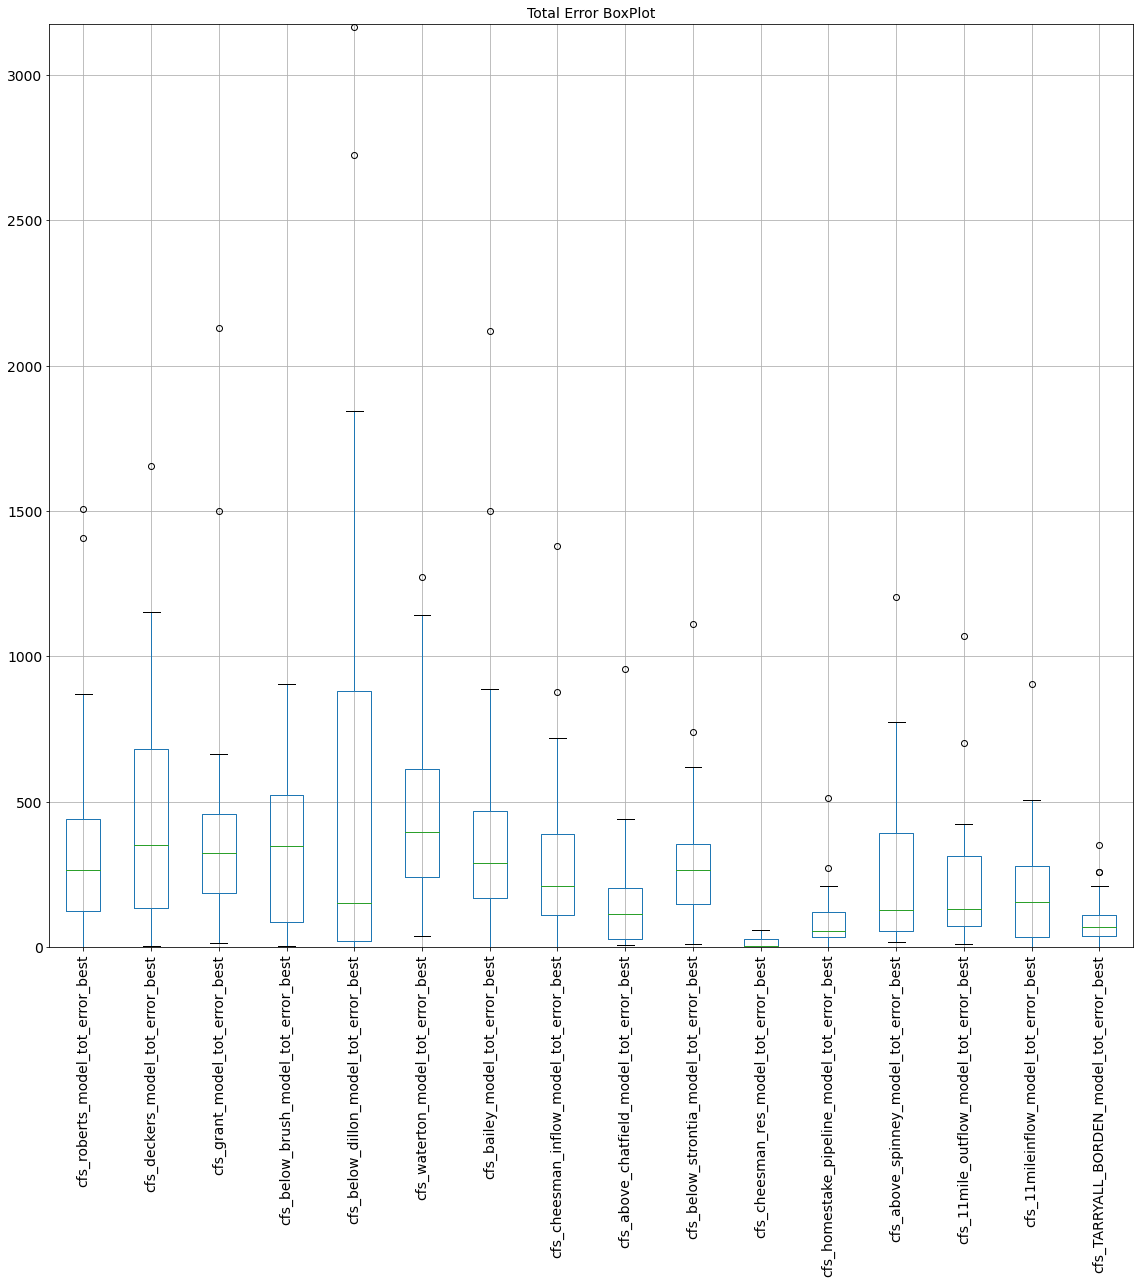

In [483]:
filled_error_list = pad_dict_list(Week_total_error_combo, float("nan"))
error_df = pd.DataFrame.from_dict(filled_error_list)

plt.ylim([0, 10 + max(error_df.max()[:])])
rcParams['figure.figsize'] = 16,18
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Total Error BoxPlot", fontsize=14)
ax = error_df.boxplot(rot = 90)

plt.tight_layout()
plt.savefig(f'ErrorBoxPlot_{save_name}.png')

In [484]:
# box plots -  base only

dataset=season_selected[:]

start_week = 145
out_week = 178
total_persist_base = 0
Week_total_error_combo_base,Nash_combo_base,Willmott_combo_base = ({} for i in range(3))
persist_counts = {}

for gauge_num, gauge in enumerate(gauge_individual_models_2DLSTM_short):
    if gauge.startswith('Tmax'):
        continue
    if gauge.startswith('TMAX'):
        continue
    if gauge.startswith('cfs_conduit'):
        continue
    if gauge.startswith('days_past'):
        continue
    if gauge.startswith('elev'):
        continue
    name_model = str(gauge).replace('_model','')
    persist_gauge_total = 0
    print('name_model', name_model)
    for week_number in range(out_week, start_week, -1):

        past_history, true_future, forecast_week = create_forecast(dataset,
                   week_number, future, features_considered,
                   past,  model_base_2DLSTM,
        )
        true_future_model = true_future[f'{name_model}']
        print('for week:',(str(true_future.iloc[1:2].index[0])))
        print('true_future_model is', list(true_future_model.reset_index(drop=True)[0:4]))
 
        if max(past_history.index.year)-min(past_history.index.year) > 0:
            print('for week:',(str(true_future.iloc[1:2].index[0])),
                  'drop double year', max(past_history.index.year),
                  min(past_history.index.year))
            continue
            
        Nash, Willmott, persistence_Nash, persistence_Willmott,tot_error, \
            future_points, predicted_points, history_points, persistence_tot_error = \
            assemble_errors(name_model, stds_train_dict, means_train_dict,
                            true_future_model.reset_index(drop=True), forecast_week, past_history)

        try:
            Willmott_combo_base[f'{gauge}_Willmott_best'].append(Willmott)
        except:
            try:
                Willmott_combo_base[f'{gauge}_Willmott_best'] = [Willmott]
            except:
                print('oops: ', Willmott)
        try:
            Nash_combo_base[f'{gauge}_Nash_best'].append(Nash)
        except:
            try:
                Nash_combo_base[f'{gauge}_Nash_best'] = [Nash]
            except:
                print('oops: ', Nash)
        try:
            Week_total_error_combo_base[f'{gauge}_tot_error_best'].append(tot_error)
        except:
            try:
                Week_total_error_combo_base[f'{gauge}_tot_error_best'] = [tot_error]
            except:
                print('oops: ', tot_error)
                  
    persist_counts[name_model] = out_week-start_week-persist_gauge_total
    print('persist_gauge_total ', persist_gauge_total, name_model,
         'out of ', out_week-start_week)

print('total_persist is ', total_persist)
print(persist_counts)

name_model cfs_roberts
for week: 2015-08-10 00:00:00
true_future_model is [-0.8806555850132286, -0.8806555850132286, -0.8806555850132286, -0.8806555850132286]
for week: 2015-08-17 00:00:00
true_future_model is [-0.8806555850132286, -0.8806555850132286, -0.8806555850132286, -0.6423017628479332]
for week: 2015-08-24 00:00:00
true_future_model is [-0.23369521056456954, -0.23369521056456954, -0.23369521056456954, -0.09749302647011499]
for week: 2015-08-31 00:00:00
true_future_model is [1.2304782684508166, 1.2134529954390099, 0.9665865367678111, 0.8133590796615497]
for week: 2015-09-07 00:00:00
true_future_model is [1.3156046335098508, 1.3156046335098508, 1.111301357368169, 0.6686442590611917]
for week: 2015-09-14 00:00:00
true_future_model is [1.4007309985688847, 1.4007309985688847, 1.2645288144744302, 1.3666804525452712]
for week: 2015-09-21 00:00:00
true_future_model is [1.1198139938740723, 1.1198139938740723, 1.111301357368169, 1.2219656319449133]
for week: 2015-09-28 00:00:00
true_futu

In [485]:
for gauge in Willmott_combo:
    print(gauge, (np.mean(np.subtract(Willmott_combo[f'{gauge}'], Willmott_combo_base[f'{gauge}']))))

cfs_roberts_model_Willmott_best 0.27055964384948056
cfs_deckers_model_Willmott_best -0.05323036936541779
cfs_grant_model_Willmott_best 0.139272337828996
cfs_below_brush_model_Willmott_best 0.06082464225403247
cfs_below_dillon_model_Willmott_best 0.0755755515776521
cfs_waterton_model_Willmott_best 0.12419445509310514
cfs_bailey_model_Willmott_best 0.039869362966341686
cfs_cheesman_inflow_model_Willmott_best 0.04706707831672518
cfs_above_chatfield_model_Willmott_best 0.024873595884606314
cfs_below_strontia_model_Willmott_best 0.20634416461751012
cfs_cheesman_res_model_Willmott_best 0.21939056726170458
cfs_homestake_pipeline_model_Willmott_best 0.09889698473434007
cfs_above_spinney_model_Willmott_best -0.04832465837671919
cfs_11mile_outflow_model_Willmott_best 0.10276661968924193
cfs_11mileinflow_model_Willmott_best 0.05298067049892664
cfs_TARRYALL_BORDEN_model_Willmott_best 0.16359530962635707


In [486]:
for gauge in Week_total_error_combo:
    print(gauge, np.mean(np.subtract(Week_total_error_combo[f'{gauge}'], Week_total_error_combo_base[f'{gauge}'])))

cfs_roberts_model_tot_error_best -196.30314559936522
cfs_deckers_model_tot_error_best -87.95908152262369
cfs_grant_model_tot_error_best -78.63167775472002
cfs_below_brush_model_tot_error_best -98.76708730061848
cfs_below_dillon_model_tot_error_best -58.243307749430336
cfs_waterton_model_tot_error_best -150.54750366210936
cfs_bailey_model_tot_error_best -60.01583543246843
cfs_cheesman_inflow_model_tot_error_best -65.8094149846745
cfs_above_chatfield_model_tot_error_best -29.090671030680337
cfs_below_strontia_model_tot_error_best -11.105938975016276
cfs_cheesman_res_model_tot_error_best -31.87245378494263
cfs_homestake_pipeline_model_tot_error_best -49.193607152303066
cfs_above_spinney_model_tot_error_best -49.67245890299479
cfs_11mile_outflow_model_tot_error_best -75.32539469401041
cfs_11mileinflow_model_tot_error_best -21.63462956746419
cfs_TARRYALL_BORDEN_model_tot_error_best -35.54358514122876


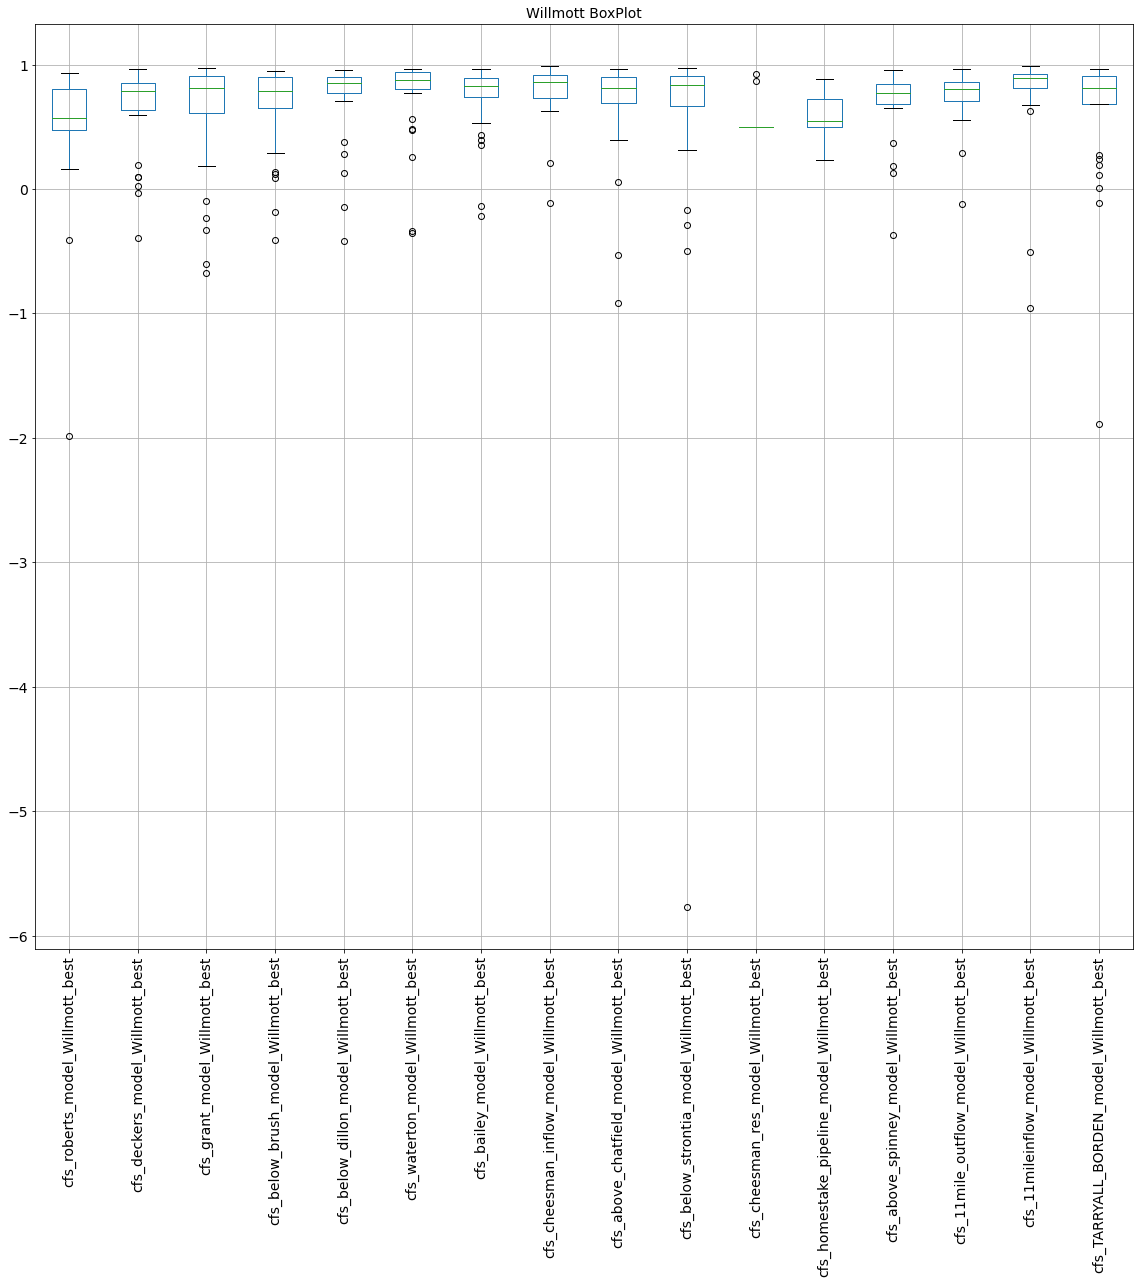

In [487]:
save_name=str('Manuscript_version_FlatBase_final')
rcParams['figure.figsize'] = (8,7)

filled_error_list = pad_dict_list(Willmott_combo_base, float("nan"))
error_df = pd.DataFrame.from_dict(filled_error_list)

rcParams['figure.figsize'] = 16,18
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Willmott BoxPlot", fontsize=14)
ax = error_df.boxplot(rot = 90)

plt.tight_layout()
plt.savefig(f'WillmottBoxPlot_{save_name}.png')

cfs_roberts_model_Nash_best 3
cfs_deckers_model_Nash_best 12
cfs_grant_model_Nash_best 8
cfs_below_brush_model_Nash_best 6
cfs_below_dillon_model_Nash_best 8
cfs_waterton_model_Nash_best 13
cfs_bailey_model_Nash_best 6
cfs_cheesman_inflow_model_Nash_best 6
cfs_above_chatfield_model_Nash_best 6
cfs_below_strontia_model_Nash_best 3
cfs_cheesman_res_model_Nash_best 2
cfs_homestake_pipeline_model_Nash_best 6
cfs_above_spinney_model_Nash_best 5
cfs_11mile_outflow_model_Nash_best 12
cfs_11mileinflow_model_Nash_best 14
cfs_TARRYALL_BORDEN_model_Nash_best 12


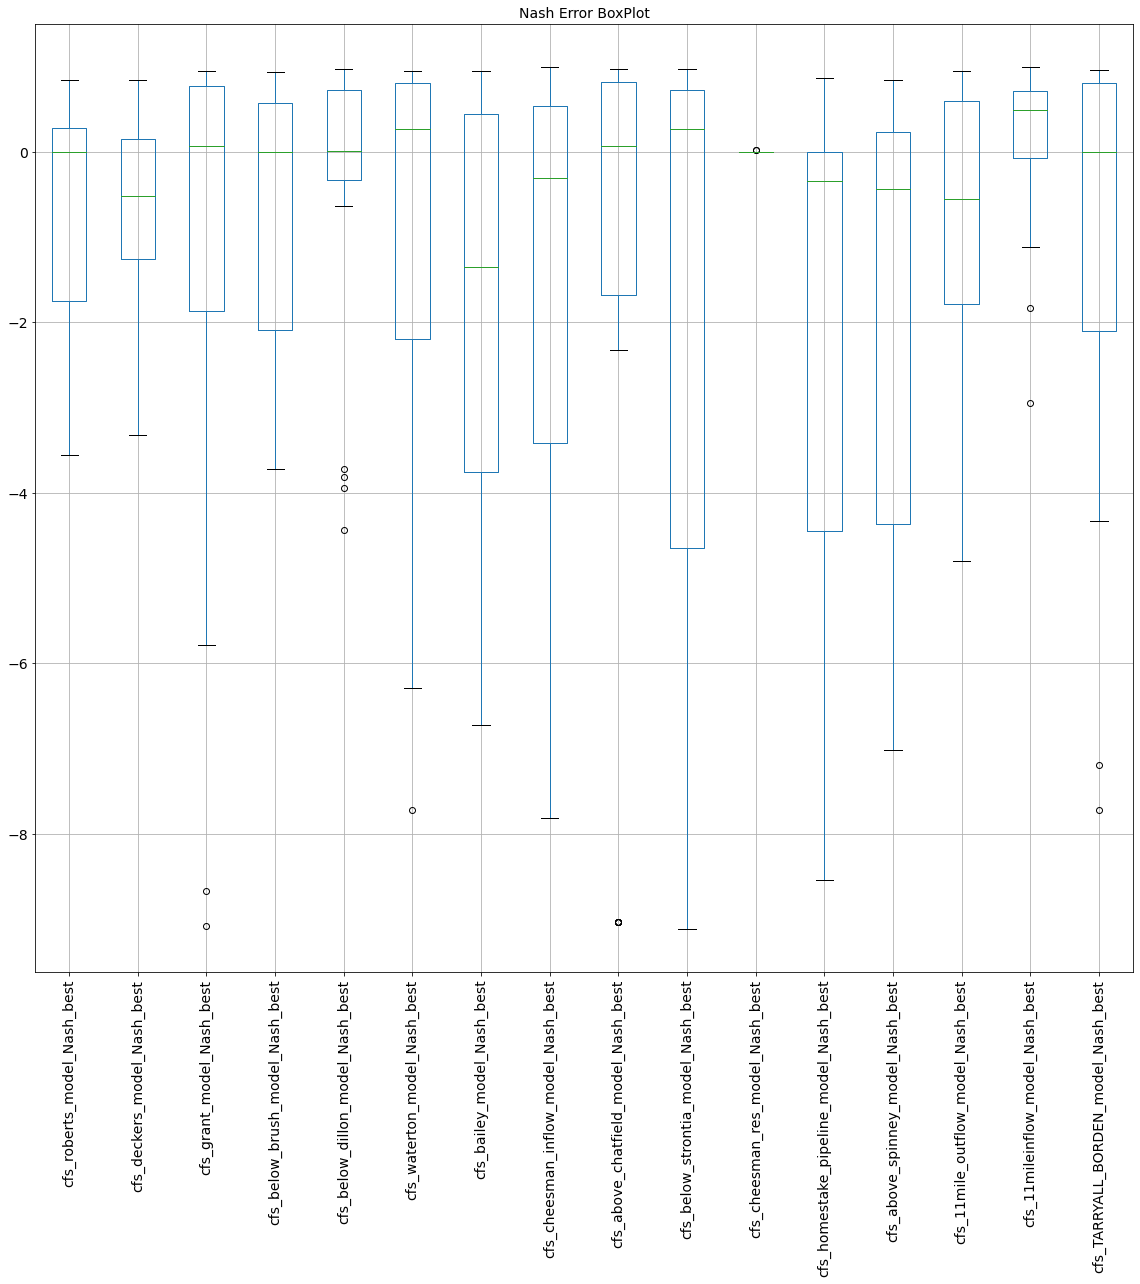

In [488]:
filled_error_list = pad_dict_list(Nash_combo_base, float("nan"))
error_df = pd.DataFrame.from_dict(filled_error_list)

for col in error_df.columns:
    replaced_outliers = 0
    filler = np.mean(error_df[col])
    IQR_cutoff = out_iqr(error_df[col], low = 25, k = 1)

    for count, x in enumerate(error_df[col]):
        
        if error_df[col][count] > IQR_cutoff[1]:
            error_df[col][count] = filler
            replaced_outliers += 1
            
        if error_df[col][count] < IQR_cutoff[0]:
            error_df[col][count] = filler
            replaced_outliers += 1
            
        if error_df[col][count] < -10:
            error_df[col][count] = float('nan')
            replaced_outliers += 1

    print(col, replaced_outliers)

rcParams['figure.figsize'] = 16,18
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Nash Error BoxPlot", fontsize=14)
ax = error_df.boxplot(rot = 90)

plt.tight_layout()
plt.savefig(f'NashBoxPlot_{save_name}.png')

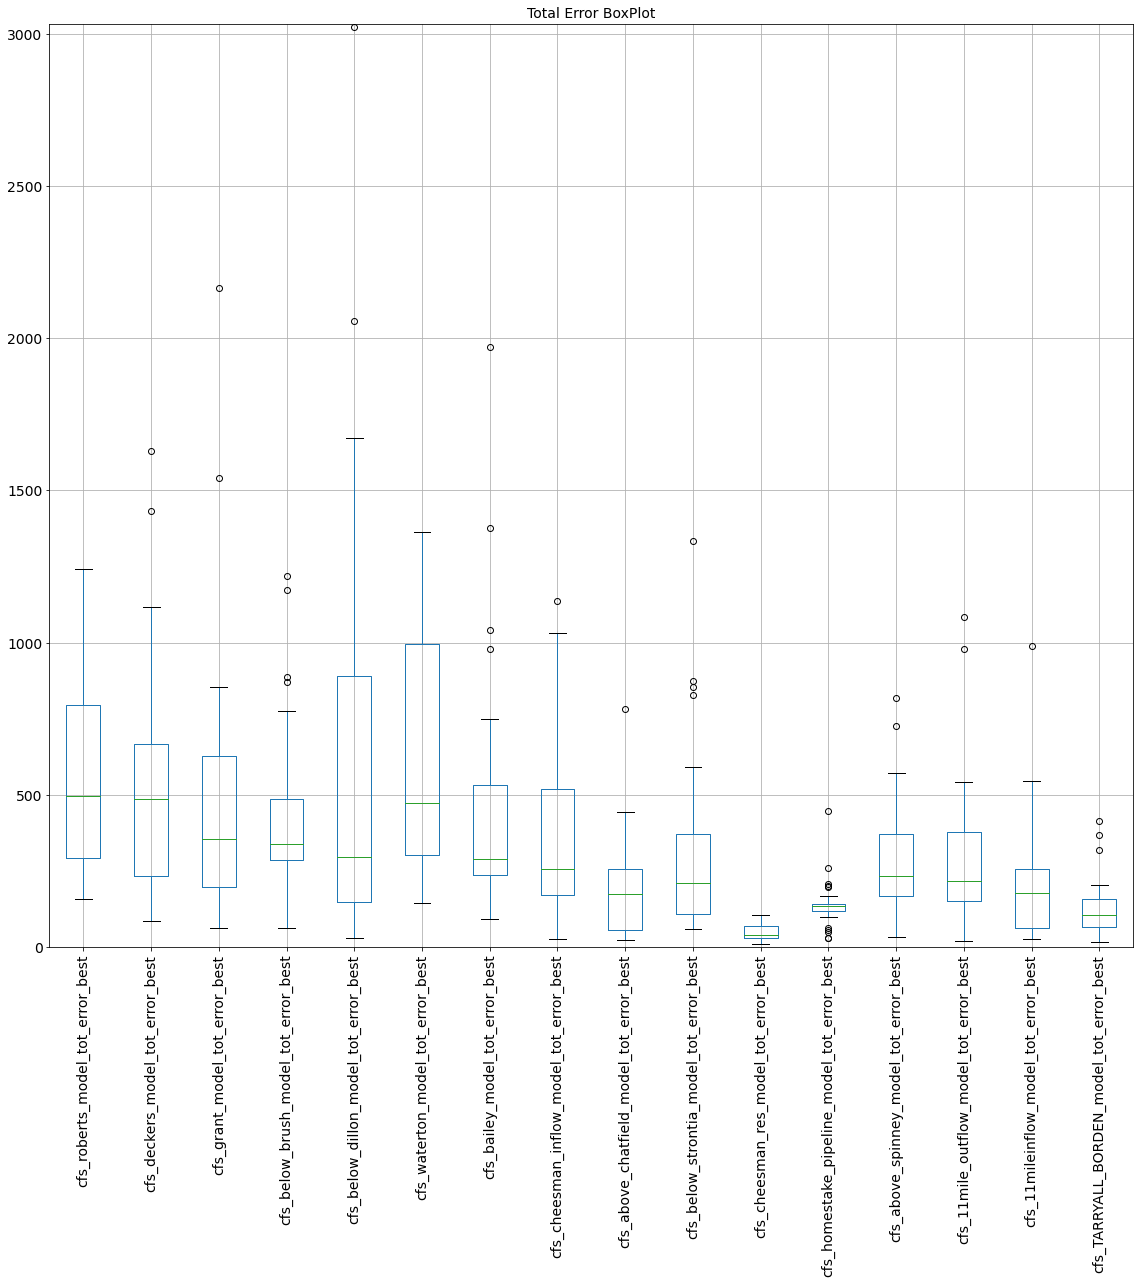

In [489]:
filled_error_list = pad_dict_list(Week_total_error_combo_base, float("nan"))
error_df = pd.DataFrame.from_dict(filled_error_list)

plt.ylim([0, 10 + max(error_df.max()[:])])
rcParams['figure.figsize'] = 16,18
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.title("Total Error BoxPlot", fontsize=14)
ax = error_df.boxplot(rot = 90)

plt.tight_layout()
plt.savefig(f'ErrorBoxPlot_{save_name}.png')